In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import talib as ta

In [ ]:
url = 'https://indodax.com'

In [ ]:
def get_pairs() :
    return requests.get(url + '/api/pairs').json()

In [ ]:
def get_ticker(pairid, timeframe, timefrom, timeto) :
    return requests.get(url + '/tradingview/history_v2?from=' + str(timefrom) + '&symbol=' + pairid +'&tf=' + timeframe + '&to=' + str(timeto)).json()

In [ ]:
def show_chart(df, tickername) :
    # Membuat figure dan dua subplot yang berbagi sumbu x
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(14, 10))

    # Plot pertama: Pergerakan Harga
    ax1.plot(df['Date'], df['Close'], label=f'{tickername}/BTC', color='blue')
    # ax1.plot(df['Date'], df['EMA_13'], linewidth=0.5, label='EMA 13', color='yellow')
    # ax1.plot(df['Date'], df['EMA_21'], linewidth=0.5, label='EMA 21', color='orange')
    ax1.set_title(f'Pergerakan Harga {tickername} terhadap BTC')
    ax1.set_ylabel('Harga (BTC)')
    ax1.legend()
    ax1.grid(True)

    # Plot kedua: RSI
    ax2.plot(df['Date'], df['RSI_14'], label=f'RSI {tickername}/BTC', color='orange')
    ax2.axhline(70, linestyle='--', alpha=0.5, color='red')  # Garis overbought
    ax2.axhline(30, linestyle='--', alpha=0.5, color='green')  # Garis oversold
    ax2.set_title(f'Grafik RSI {tickername} terhadap BTC')
    ax2.set_xlabel('Tanggal')
    ax2.set_ylabel('RSI')
    ax2.legend()
    ax2.grid(True)

    ax3.plot(df['Date'], df['Stoch_%K'], label='%K', color='blue')
    ax3.plot(df['Date'], df['Stoch_%D'], label='%D', color='orange')
    ax3.axhline(80, linestyle='--', alpha=0.5, color='red')  # Garis overbought
    ax3.axhline(20, linestyle='--', alpha=0.5, color='green')  # Garis oversold
    ax3.set_title(f'Grafik Stochastic {tickername} terhadap BTC')
    ax3.set_xlabel('Tanggal')
    ax3.set_ylabel('Nilai')
    ax3.legend()
    ax3.grid(True)

    # Menyesuaikan tata letak agar tidak saling tumpang tindih
    plt.tight_layout()
    plt.show()

In [ ]:
def get_df_from_ticker(ticker_name, timeframe, timefrom, timeto) :
    ticker_name = get_ticker(ticker_name + 'IDR', timeframe, timefrom, timeto)
    df_1 = pd.DataFrame(ticker_name)
    df_1['Date'] = pd.to_datetime(df_1['Time'], unit='s')
    df_1 = df_1.sort_values(by='Date')
    return df_1

In [ ]:
def get_history_btc_pair(tickername, df_coin_idr, dfbtcidr) :
    ticker_name_low = tickername.lower()
    df_merged = pd.merge(df_coin_idr, dfbtcidr, on='Date', suffixes=('_'+ticker_name_low, '_btc'))
    df_merged['Open_' + ticker_name_low +'_btc'] = df_merged['Open_' + ticker_name_low] / df_merged['Open_btc']
    df_merged['High_' + ticker_name_low +'_btc'] = df_merged['High_' + ticker_name_low] / df_merged['High_btc']
    df_merged['Low_' + ticker_name_low + '_btc'] = df_merged['Low_' + ticker_name_low] / df_merged['Low_btc']
    df_merged['Close_'+ ticker_name_low +'_btc'] = df_merged['Close_' + ticker_name_low] / df_merged['Close_btc']

    df_final = df_merged[['Date', 'Open_' + ticker_name_low +'_btc', 'High_' + ticker_name_low +'_btc', 'Low_' + ticker_name_low + '_btc', 'Close_' + ticker_name_low +'_btc']].copy()
    df_final.rename(columns={
        'Open_' + ticker_name_low +'_btc': 'Open',
        'High_' + ticker_name_low +'_btc': 'High',
        'Low_' + ticker_name_low + '_btc': 'Low',
        'Close_' + ticker_name_low +'_btc': 'Close'
    }, inplace=True)

    df_final['RSI_14'] = ta.RSI(df_final['Close'], timeperiod=14)

    slowk, slowd = ta.STOCH(df_final['High'], df_final['Low'], df_final['Close'],
                           fastk_period=5,
                           slowk_period=3,
                           slowd_period=3)
    df_final['Stoch_%K'] = slowk
    df_final['Stoch_%D'] = slowd

    # df_final['EMA_13'] = df_final['Close'].ewm(span=13, adjust=False).mean()
    # df_final['EMA_21'] = df_final['Close'].ewm(span=21, adjust=False).mean()

    return df_final

In [ ]:
pairs = get_pairs()
symbols = [item['symbol'] for item in pairs if 'symbol' in item and item['symbol'].endswith('IDR') and item['symbol'] != 'BTCIDR']
print(symbols)

In [ ]:
now = datetime.now()
past = now - timedelta(days=5*365)
timeFrom = int(time.mktime(past.timetuple()))
timeTo = int(time.mktime(now.timetuple()))
tf = '1D'

In [58]:
dfBtcIdr = get_df_from_ticker('BTC', tf, timeFrom, timeTo)
print(dfBtcIdr)

            Time        Open        High         Low       Close  \
0     1585440000   103200000   103316000    98093000    98093000   
1     1585526400    98093000   108643000    97942000   105742000   
2     1585612800   105795000   107730000   105500000   106036000   
3     1585699200   106005000   110380000   103031000   110338000   
4     1585785600   110245000   116832000   108701000   111484000   
...          ...         ...         ...         ...         ...   
1821  1742774400  1419518000  1470000000  1408400000  1445405000   
1822  1742860800  1444242000  1464623000  1430000000  1455499000   
1823  1742947200  1455499000  1466658000  1431611000  1452115000   
1824  1743033600  1452115000  1459590000  1430000000  1453251000   
1825  1743120000  1453251000  1453251000  1432010000  1433960000   

            Volume       Date  
0     192.83663706 2020-03-29  
1     594.36841136 2020-03-30  
2     381.48026559 2020-03-31  
3     452.93230584 2020-04-01  
4     710.34285861 2020

In [60]:
def show_chart_rsi(df) :
    plt.figure(figsize=(10, 6))
    plt.scatter(df['Label'], df['RSI_14'], color='blue')
    plt.axhline(70, linestyle='--', alpha=0.5, color='red', label='Overbought (70)')
    plt.axhline(30, linestyle='--', alpha=0.5, color='green', label='Oversold (30)')
    plt.title('Nilai RSI Terbaru')
    plt.xlabel('Ticker')
    plt.ylabel('RSI')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.show()

In [59]:
def show_multiple_chart(tickers) :
    rsi_list = []
    tickers.sort()

    for i, ticker in enumerate(tickers) :
        df_coin_idr_1 = get_df_from_ticker(ticker, tf, timeFrom, timeTo)
        df_btc_pair = get_history_btc_pair(ticker, df_coin_idr_1, dfBtcIdr)
        show_chart(df_btc_pair, ticker)
        latest_rsi = df_btc_pair['RSI_14'].iloc[-1]
        rsi_list.append({'Label': ticker, 'RSI_14': latest_rsi})

    rsi_list = sorted(rsi_list, key=lambda x: x['RSI_14'])
    rsi_df = pd.DataFrame(rsi_list)
    show_chart_rsi(rsi_df)

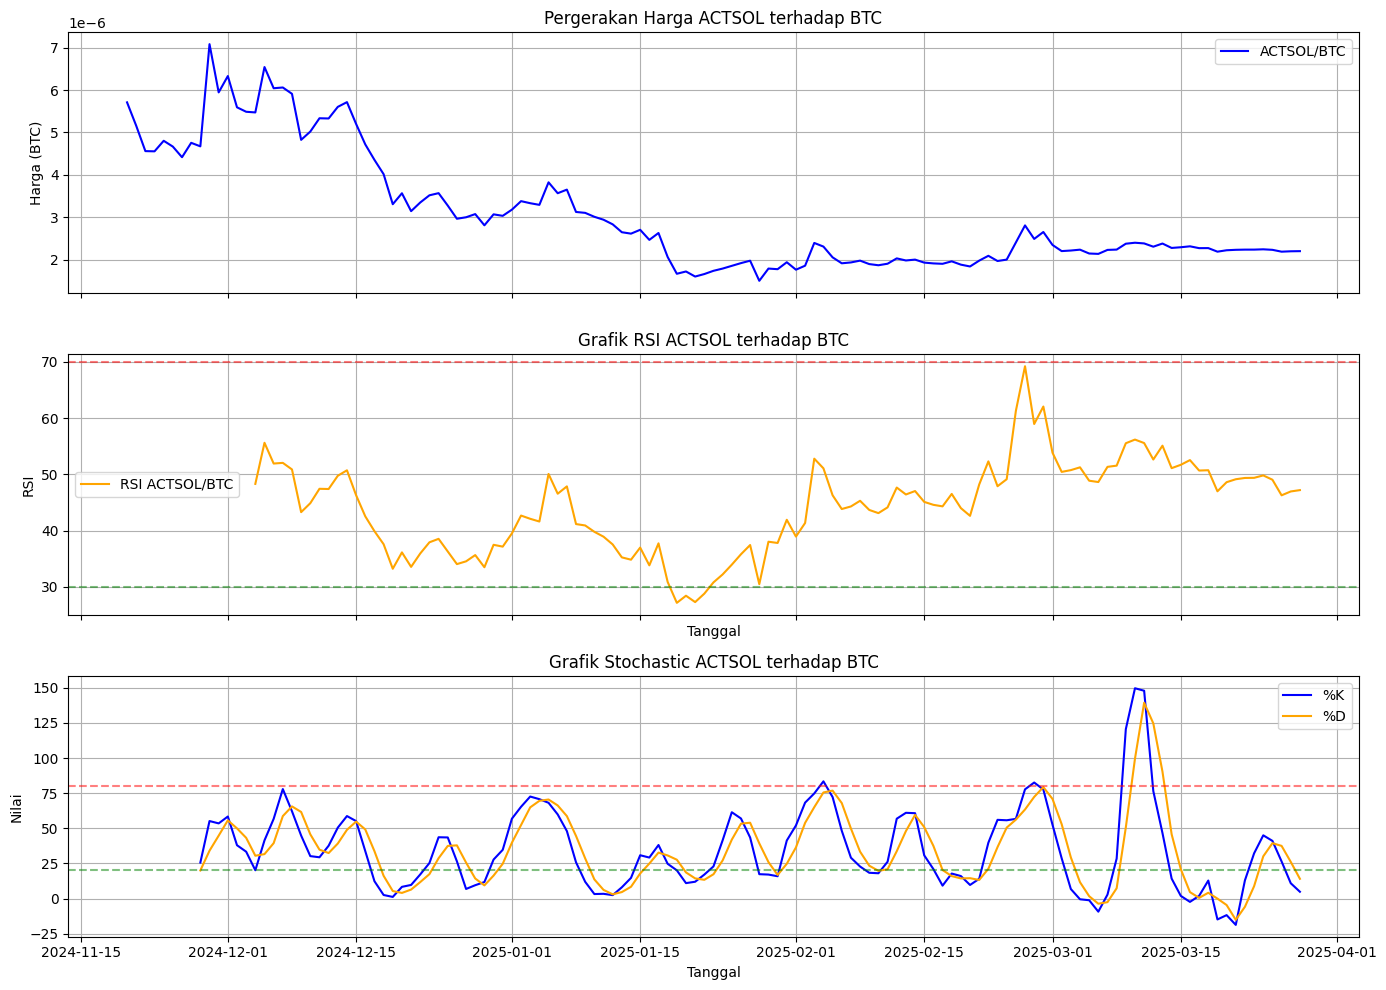

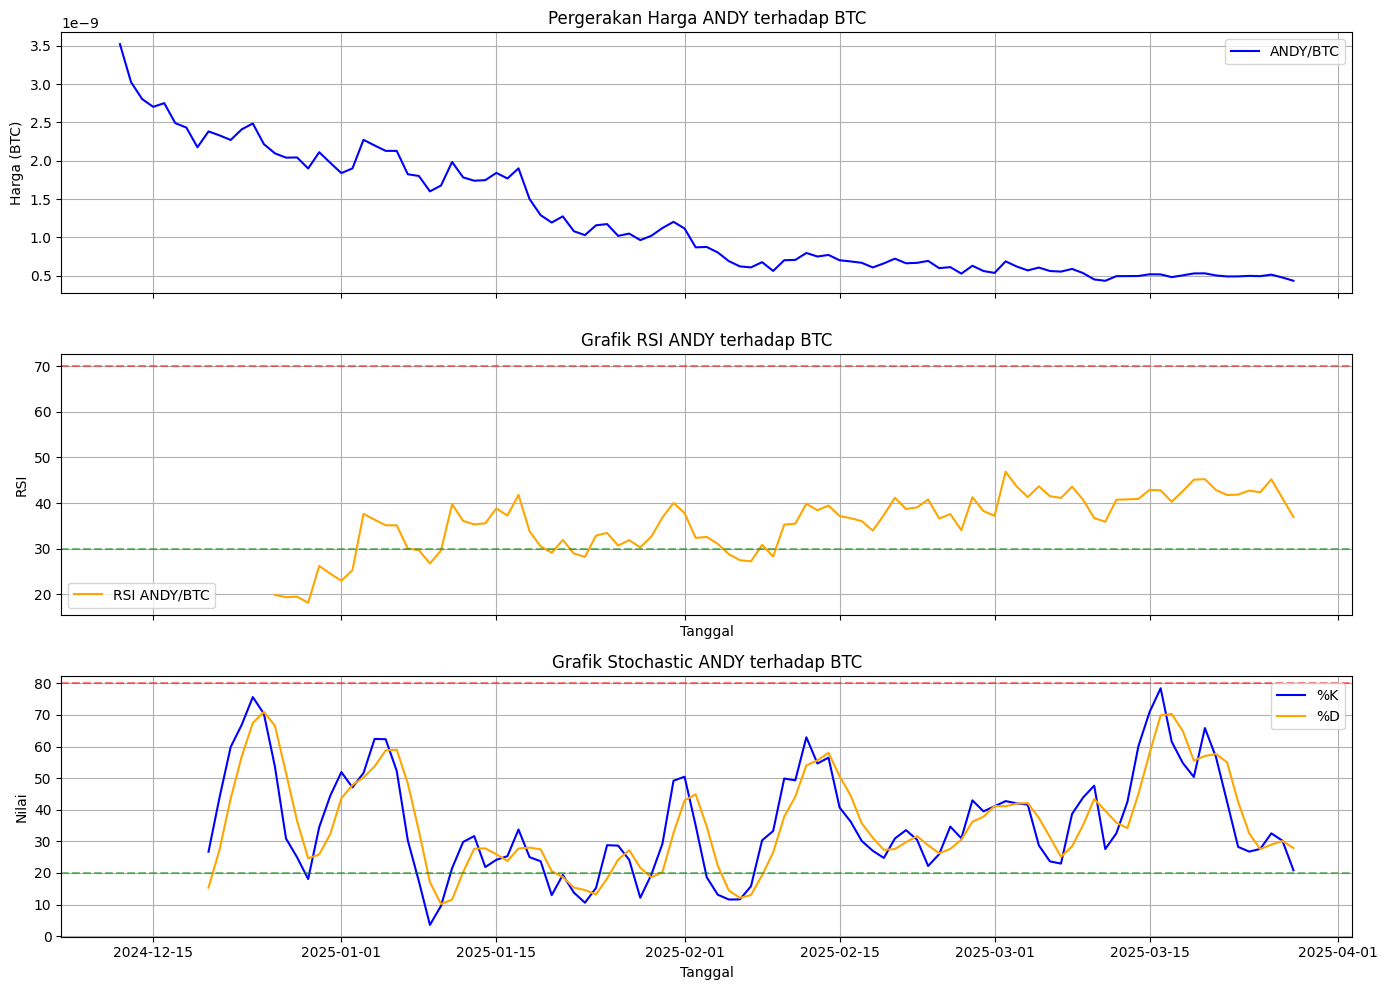

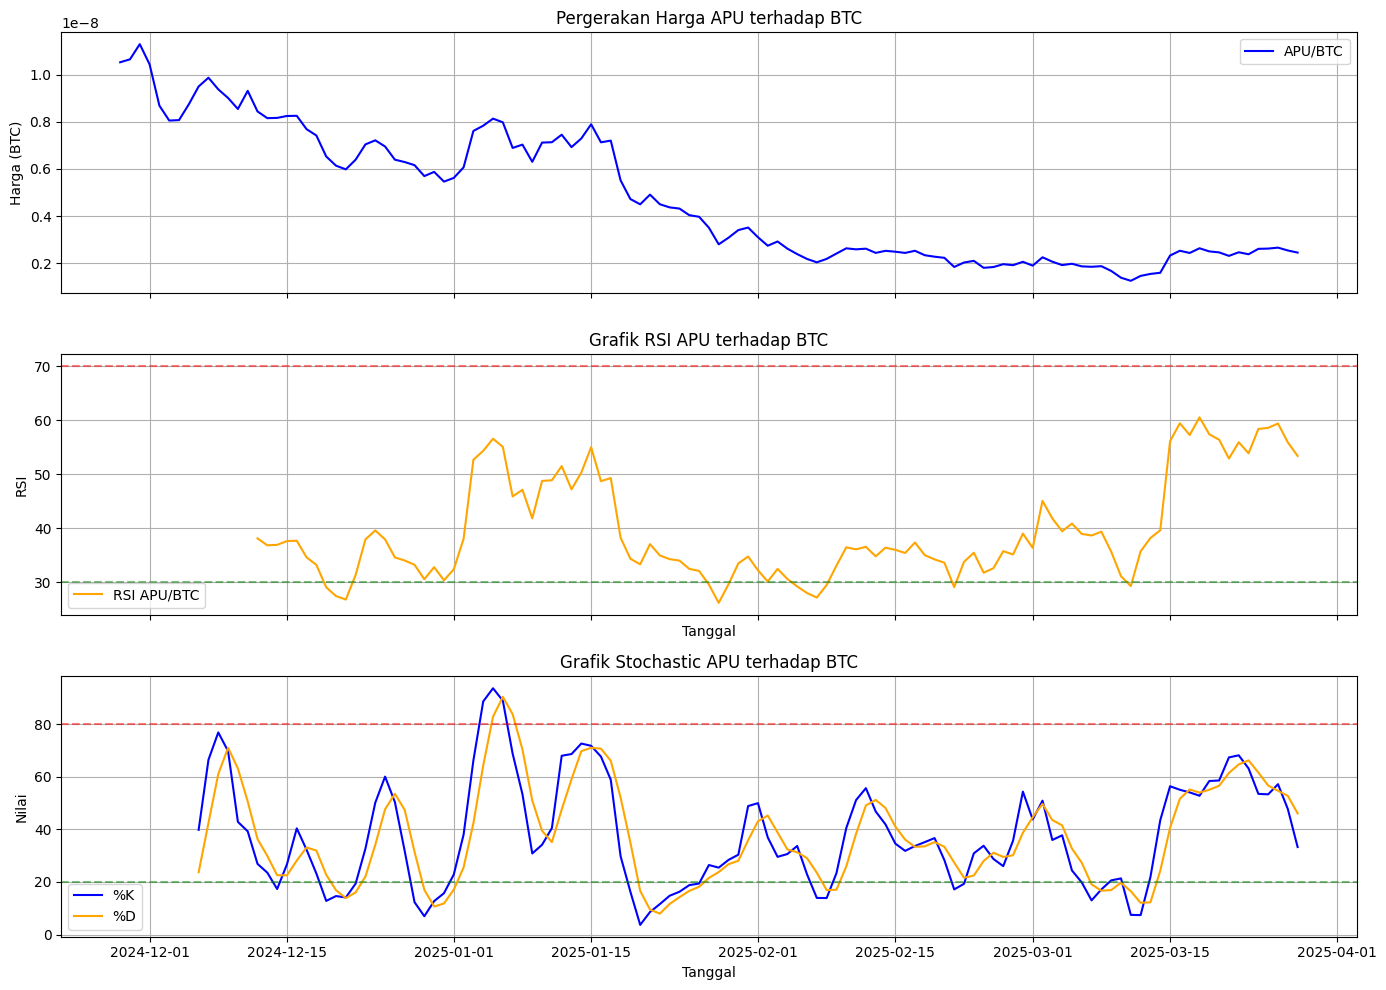

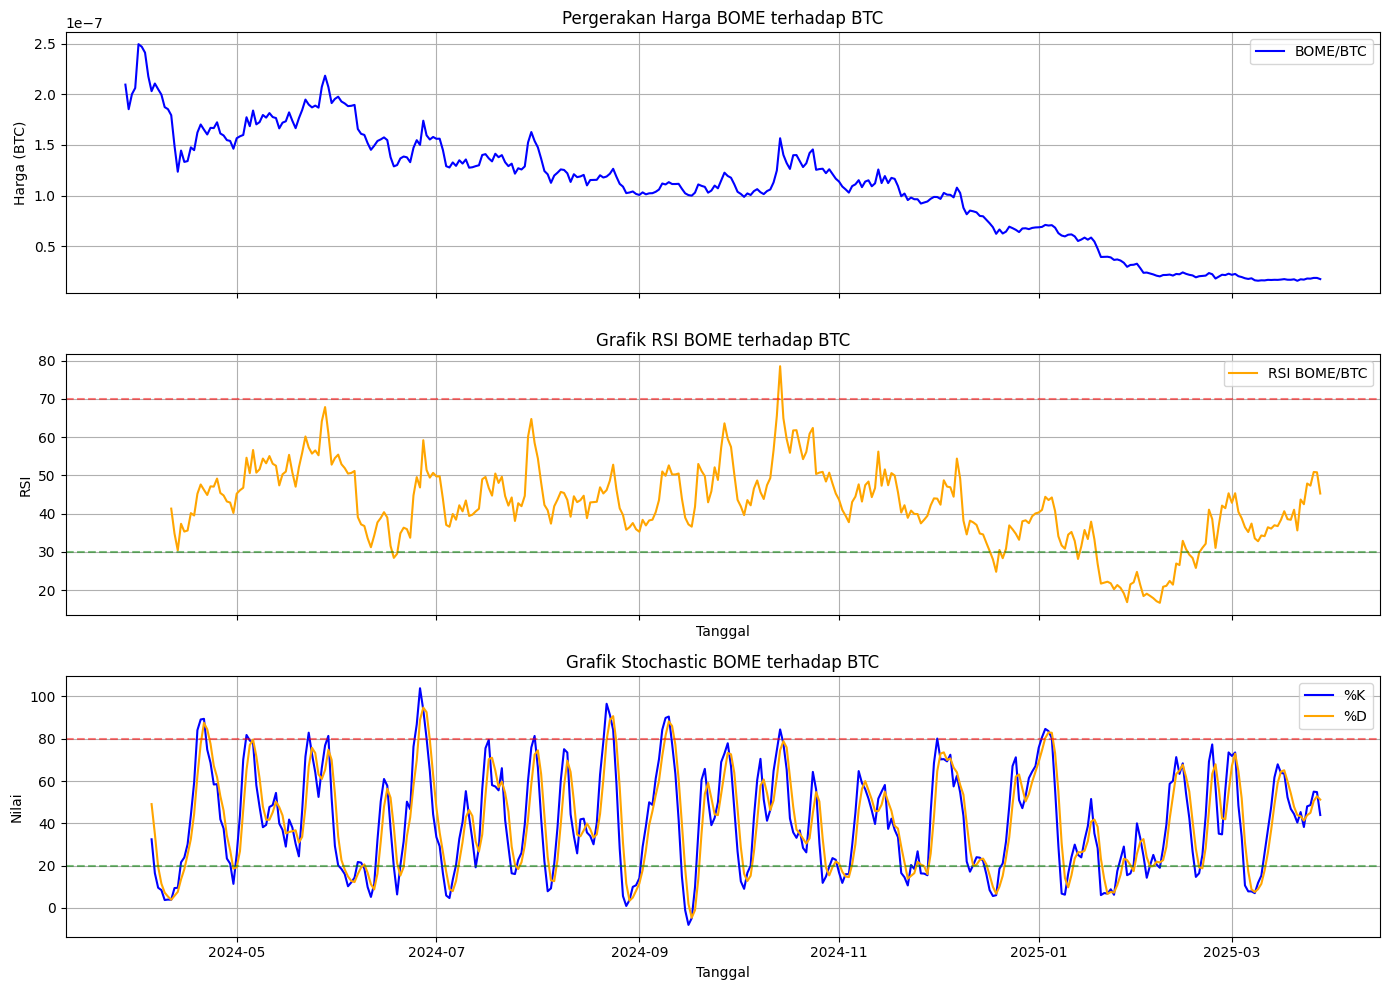

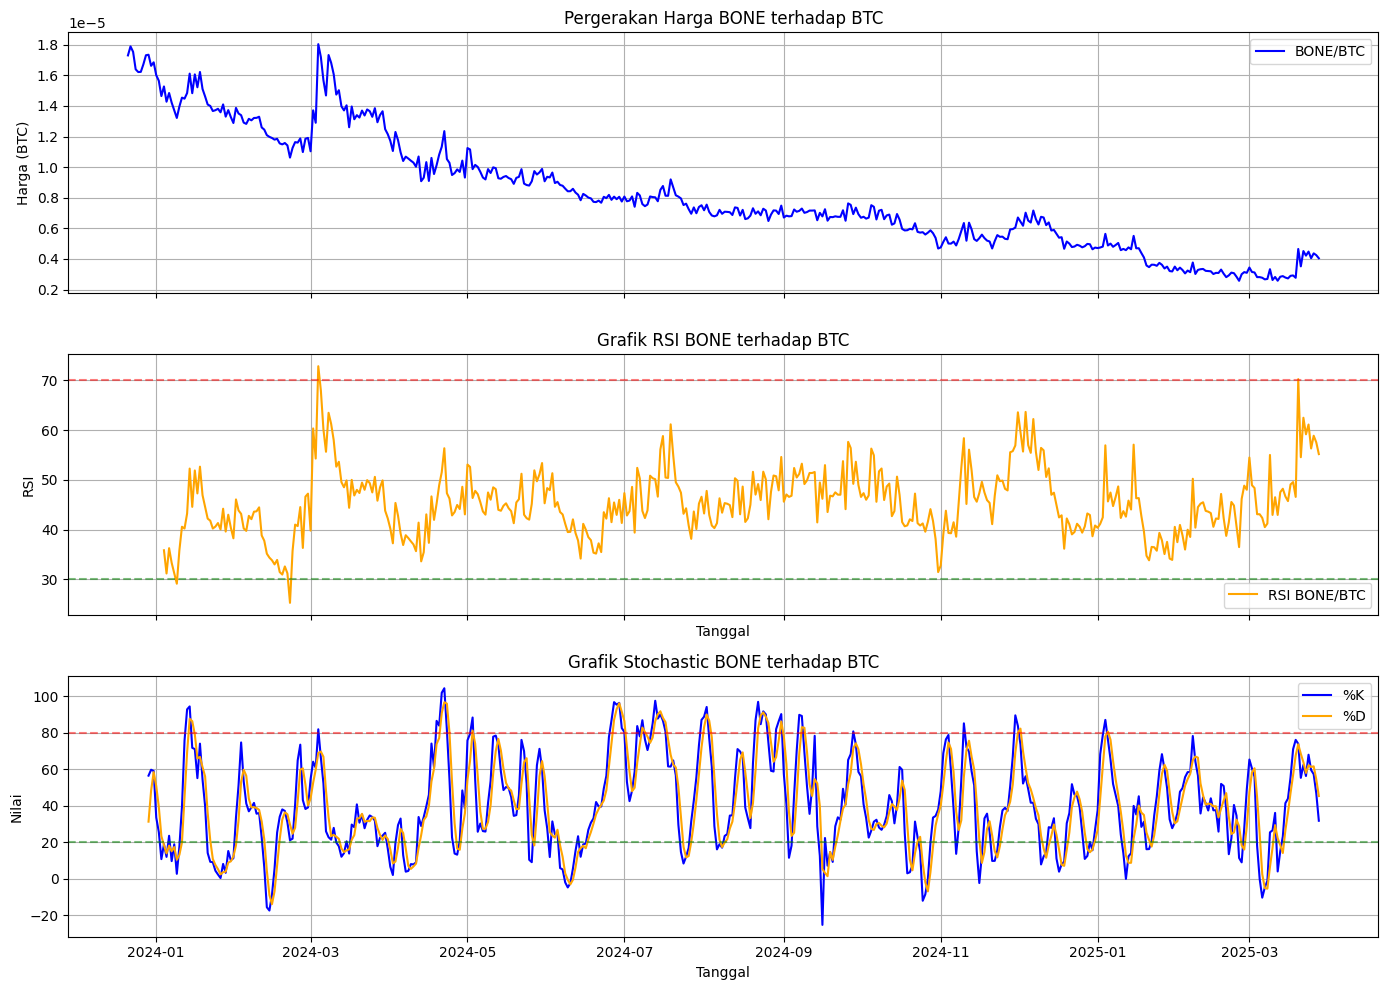

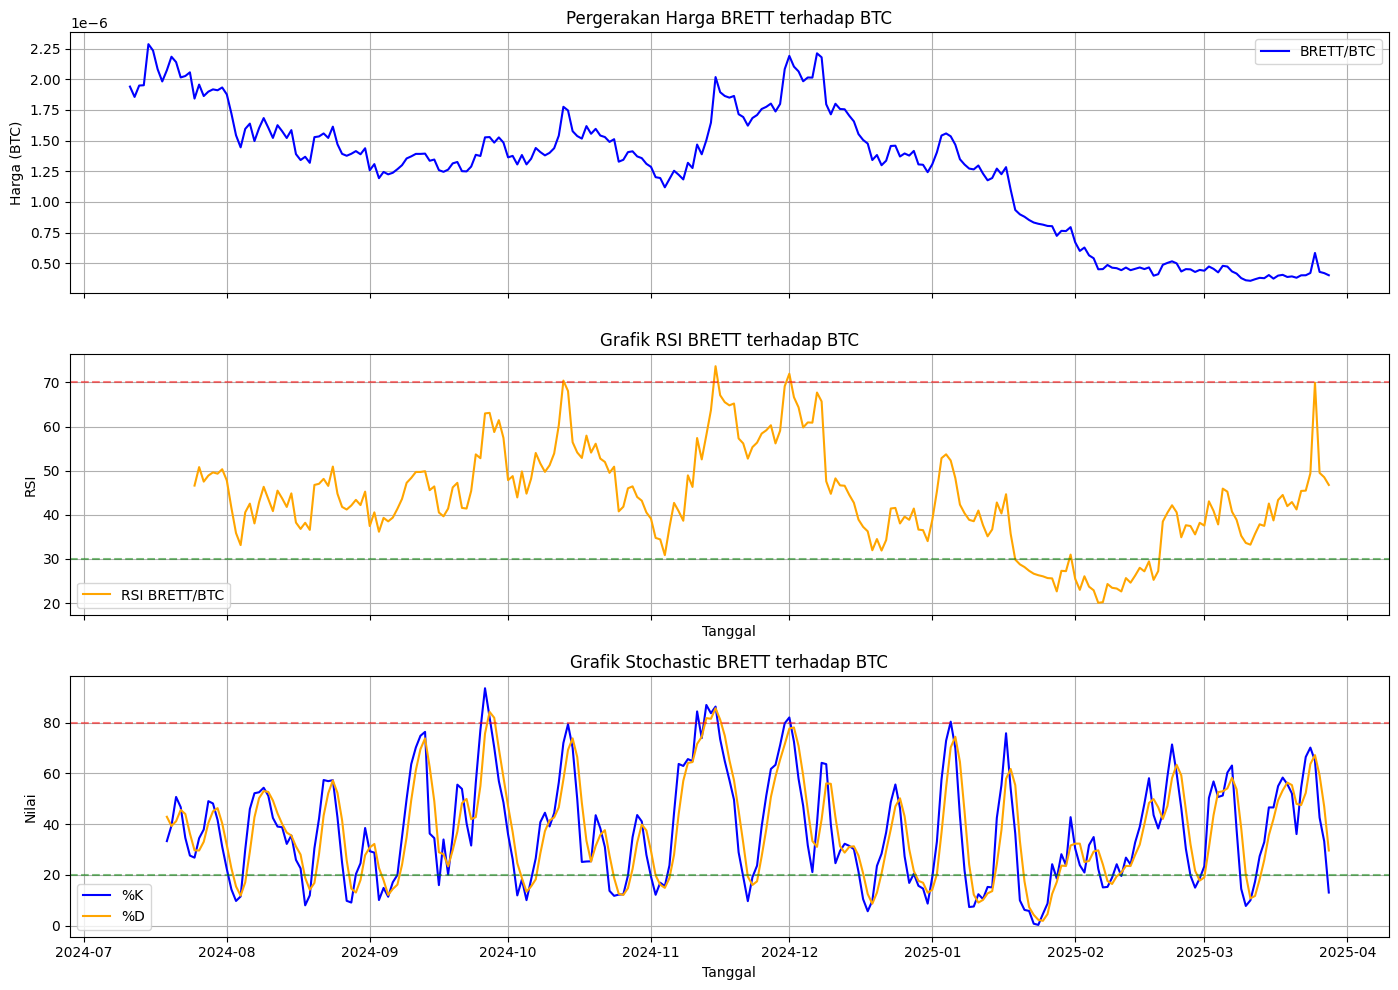

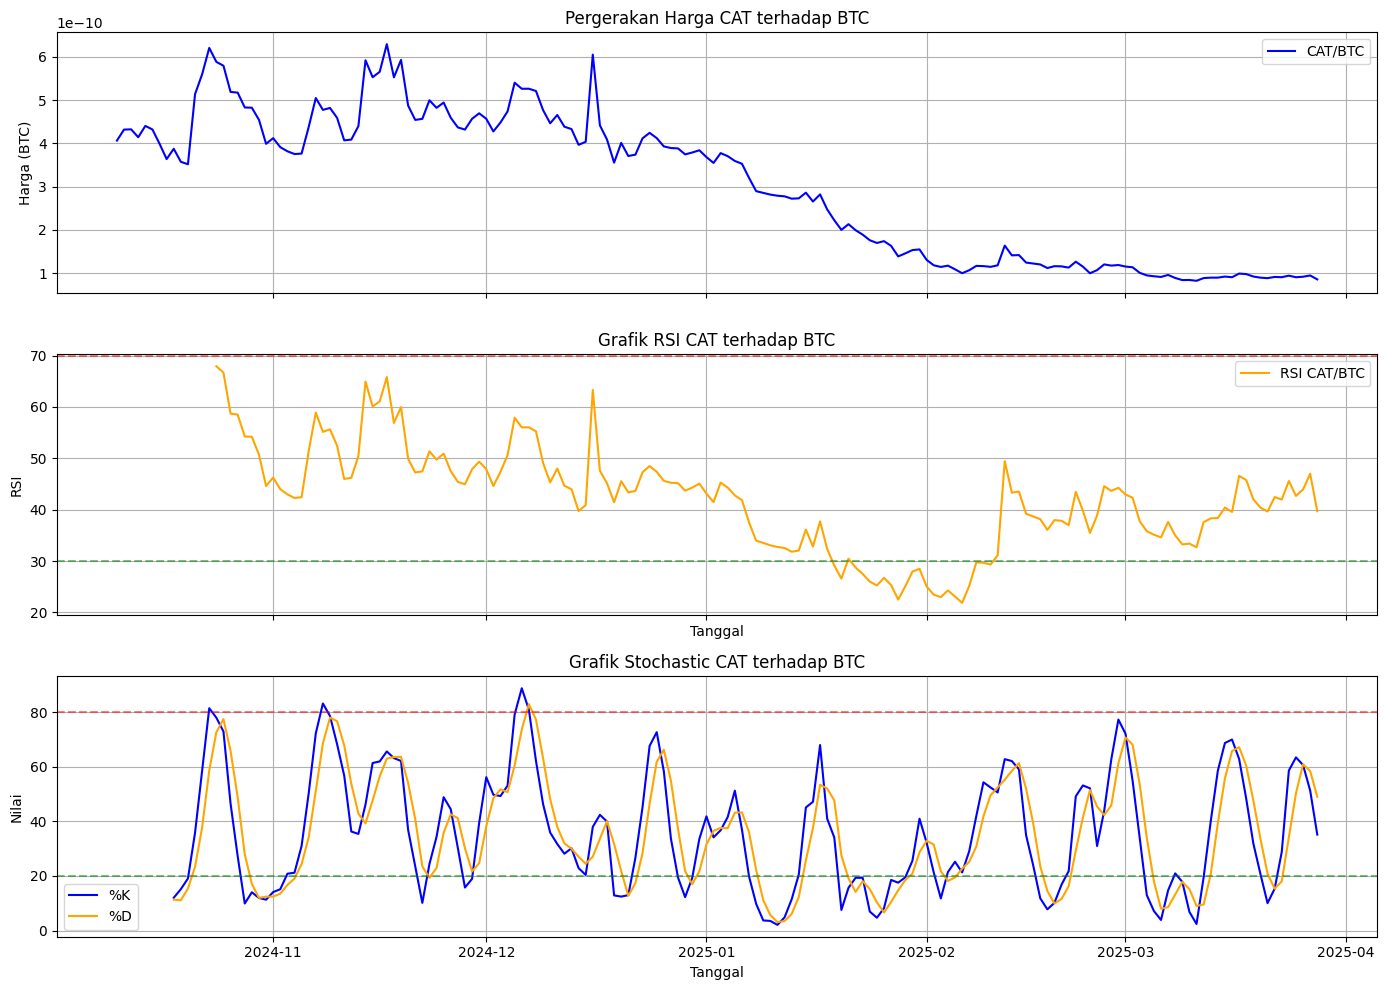

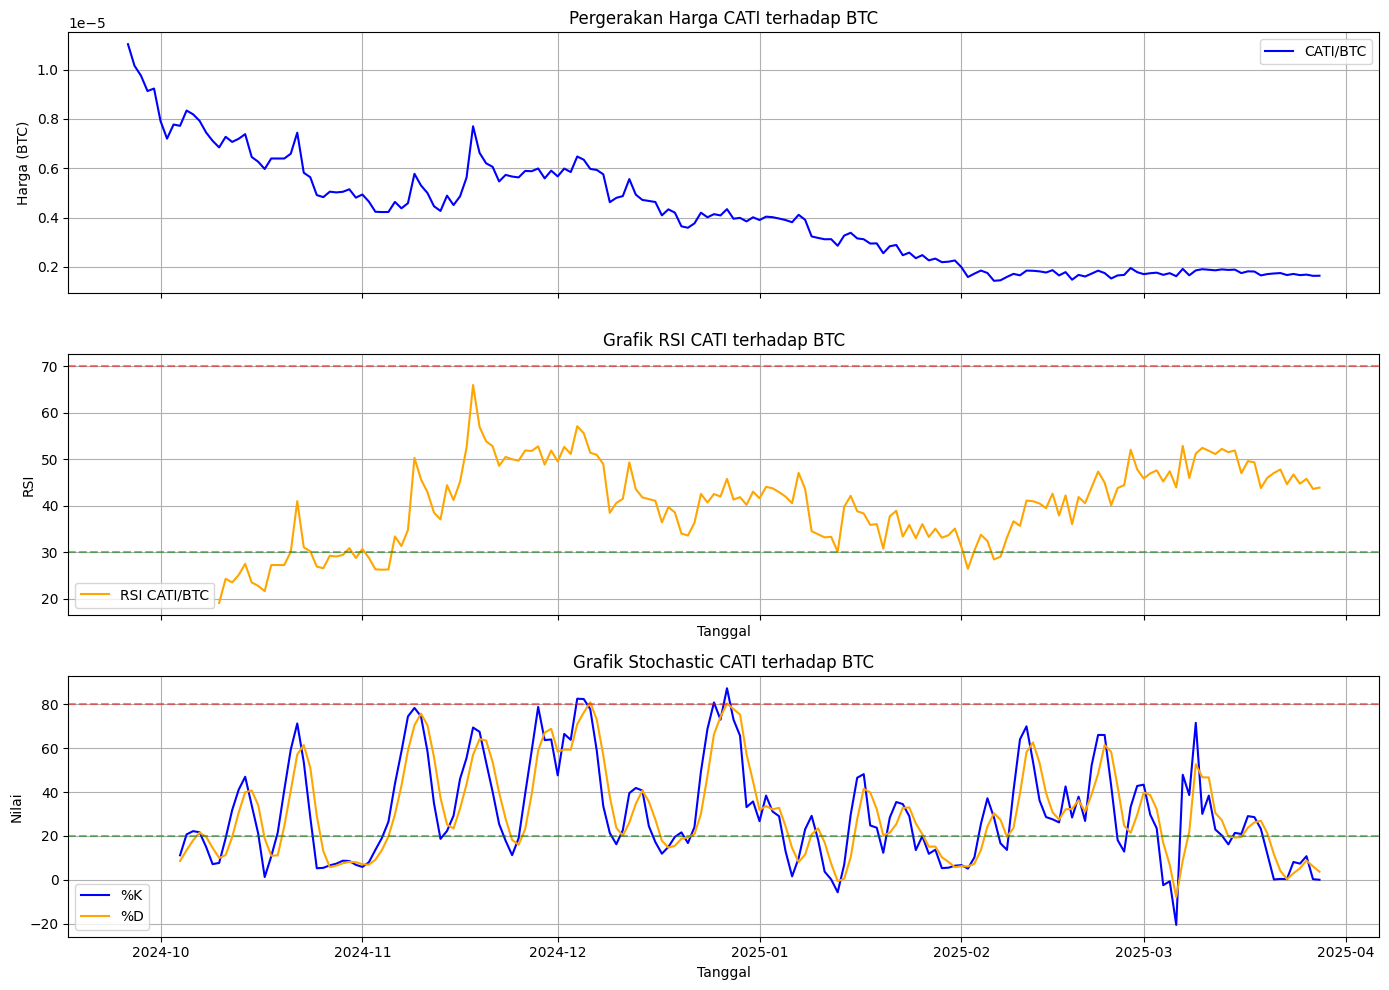

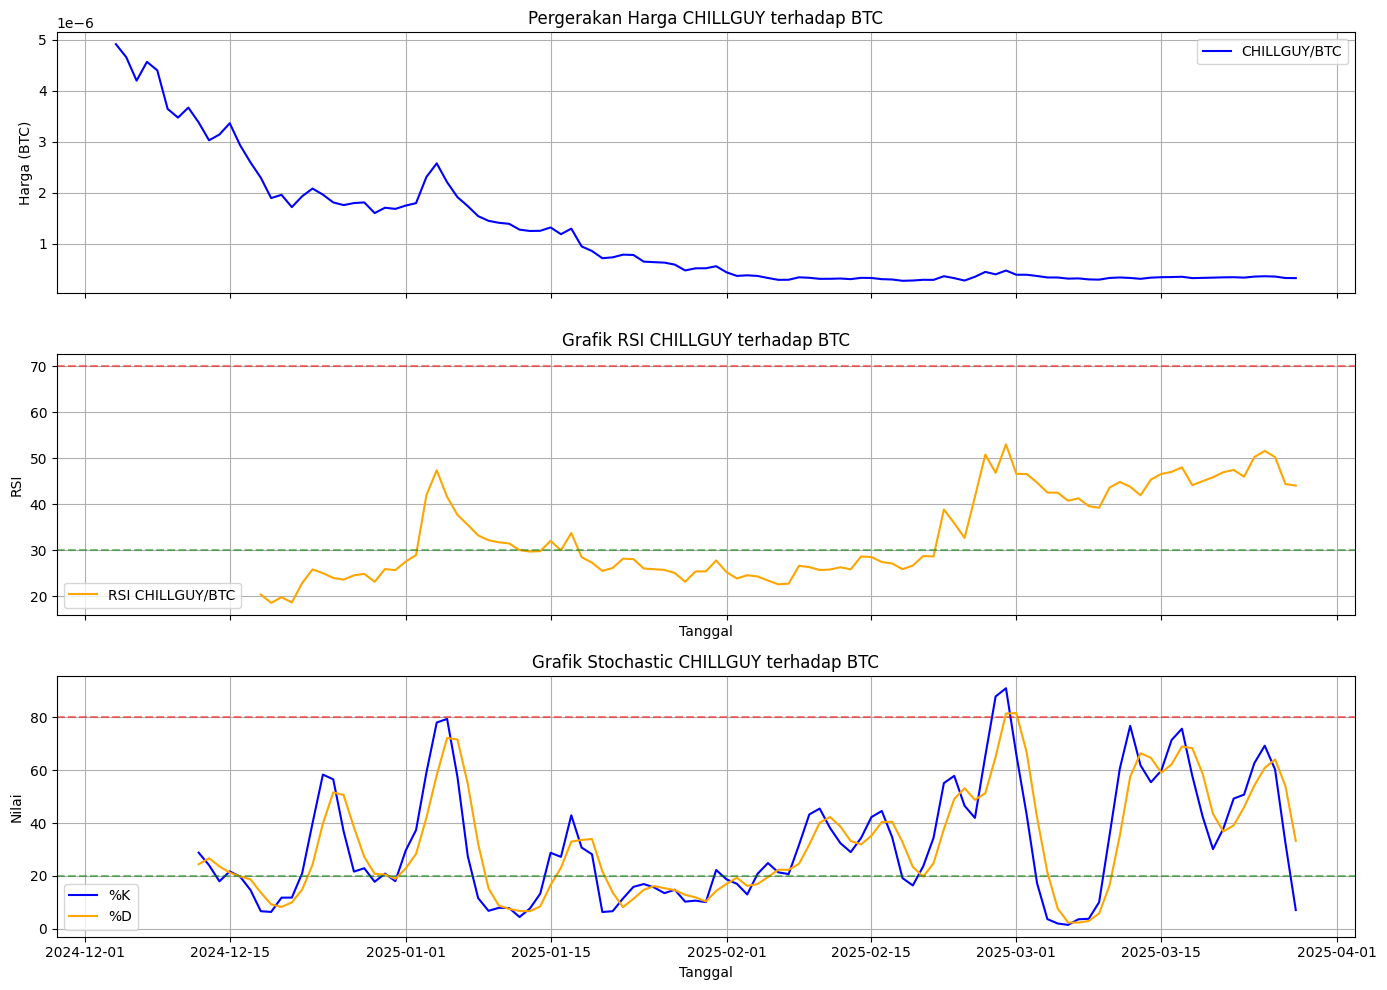

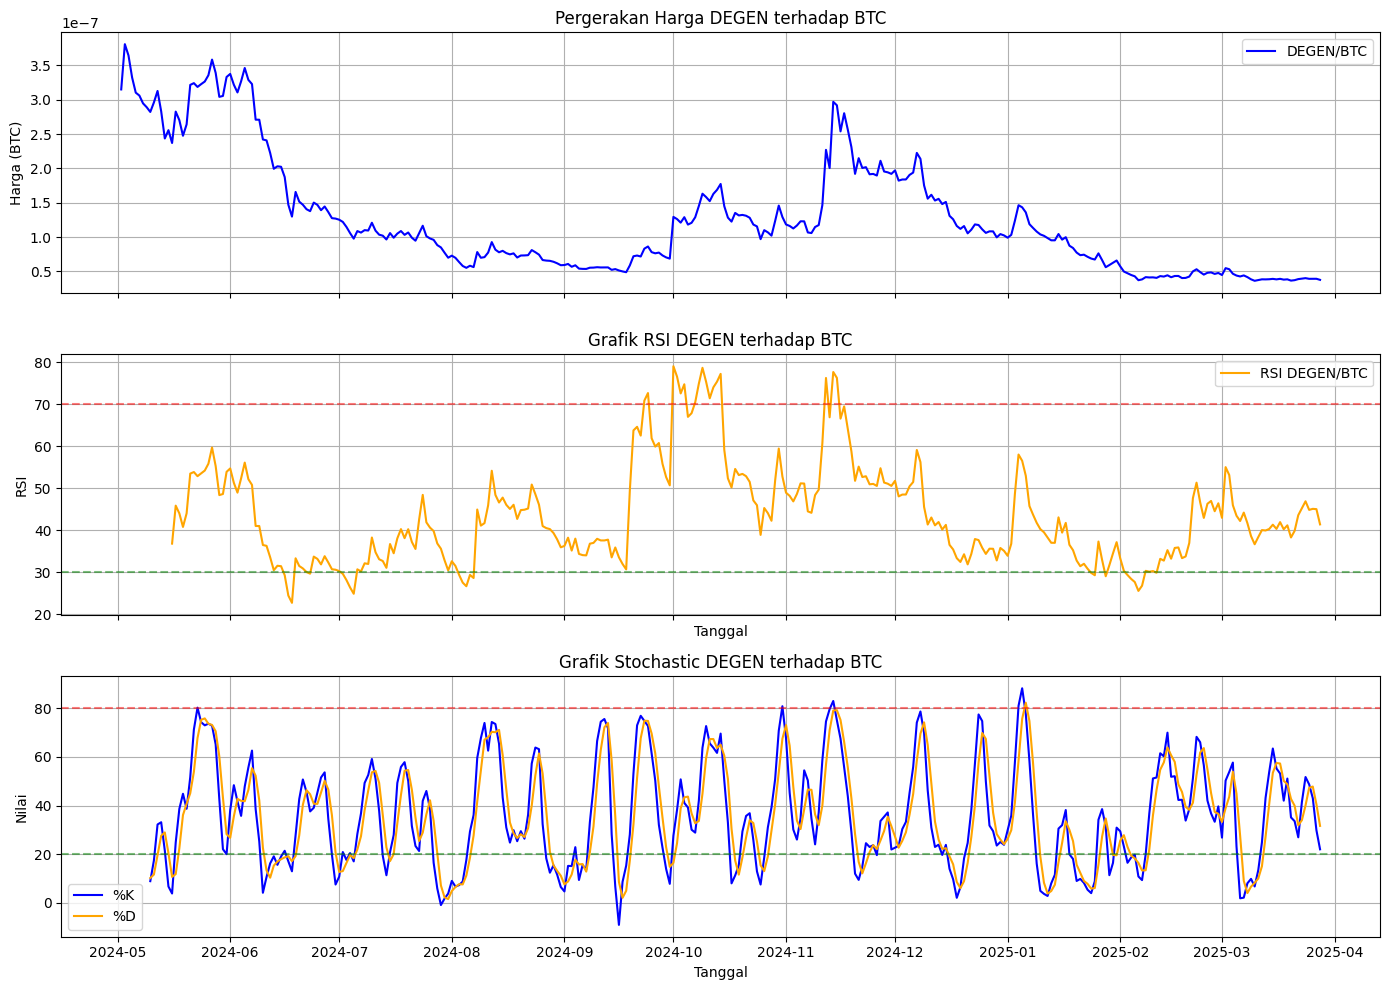

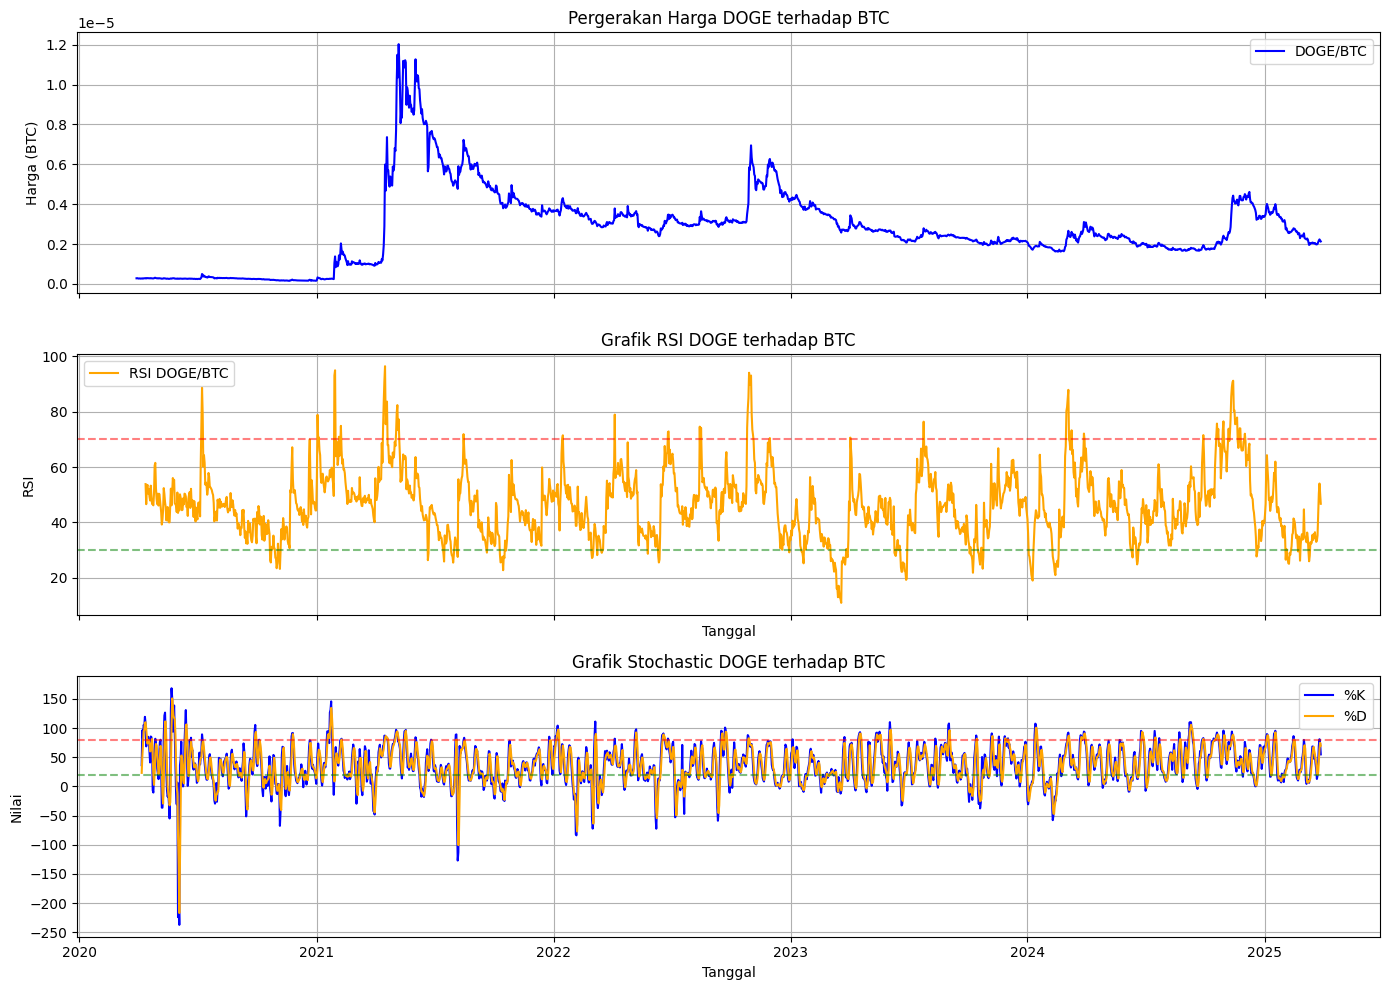

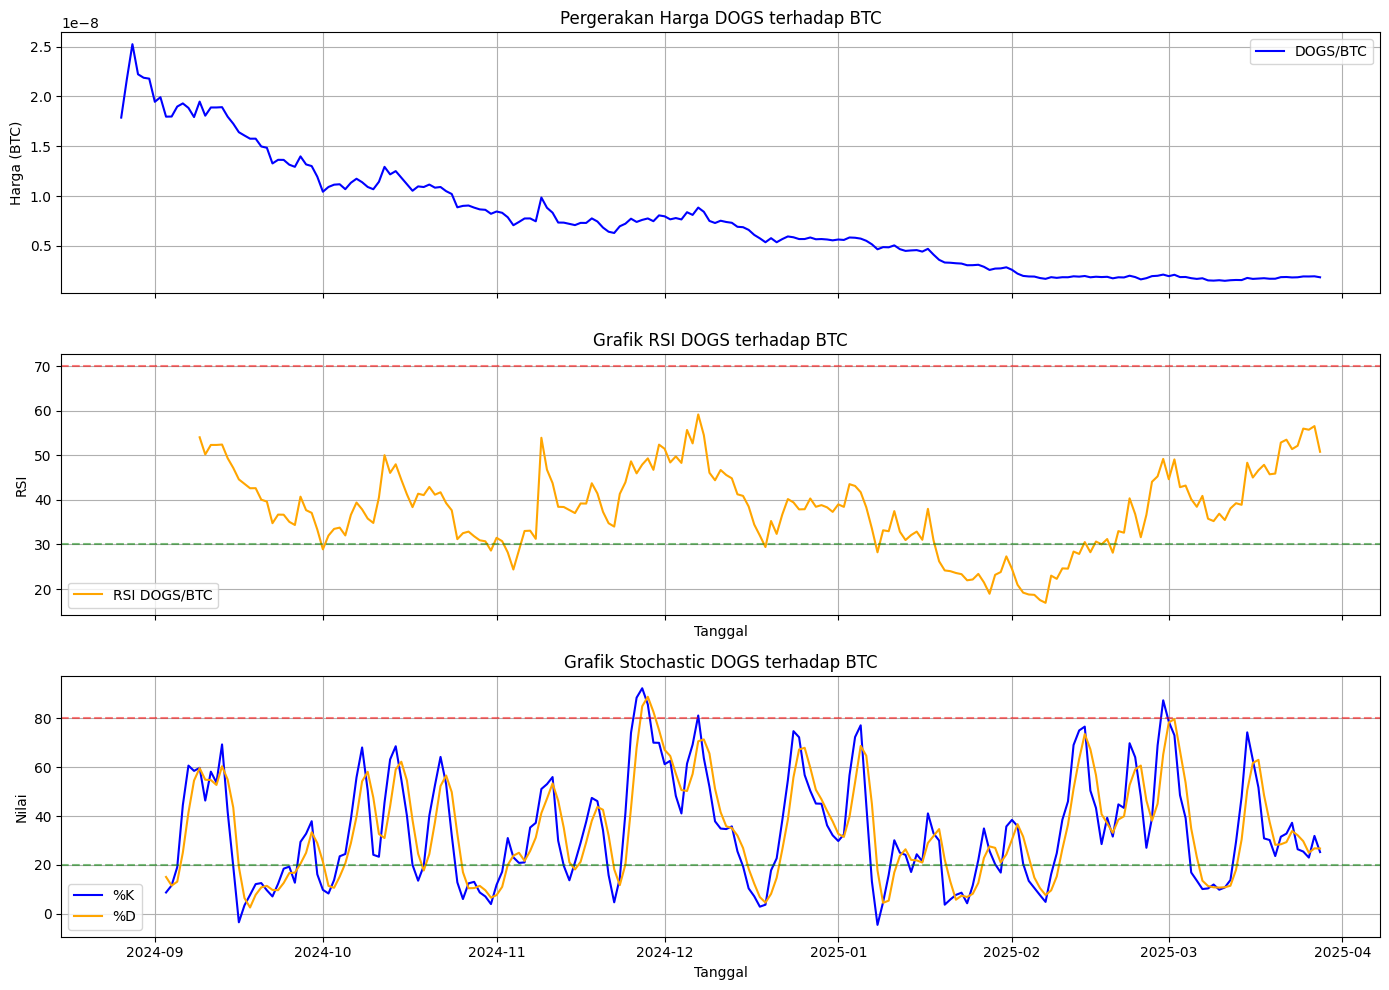

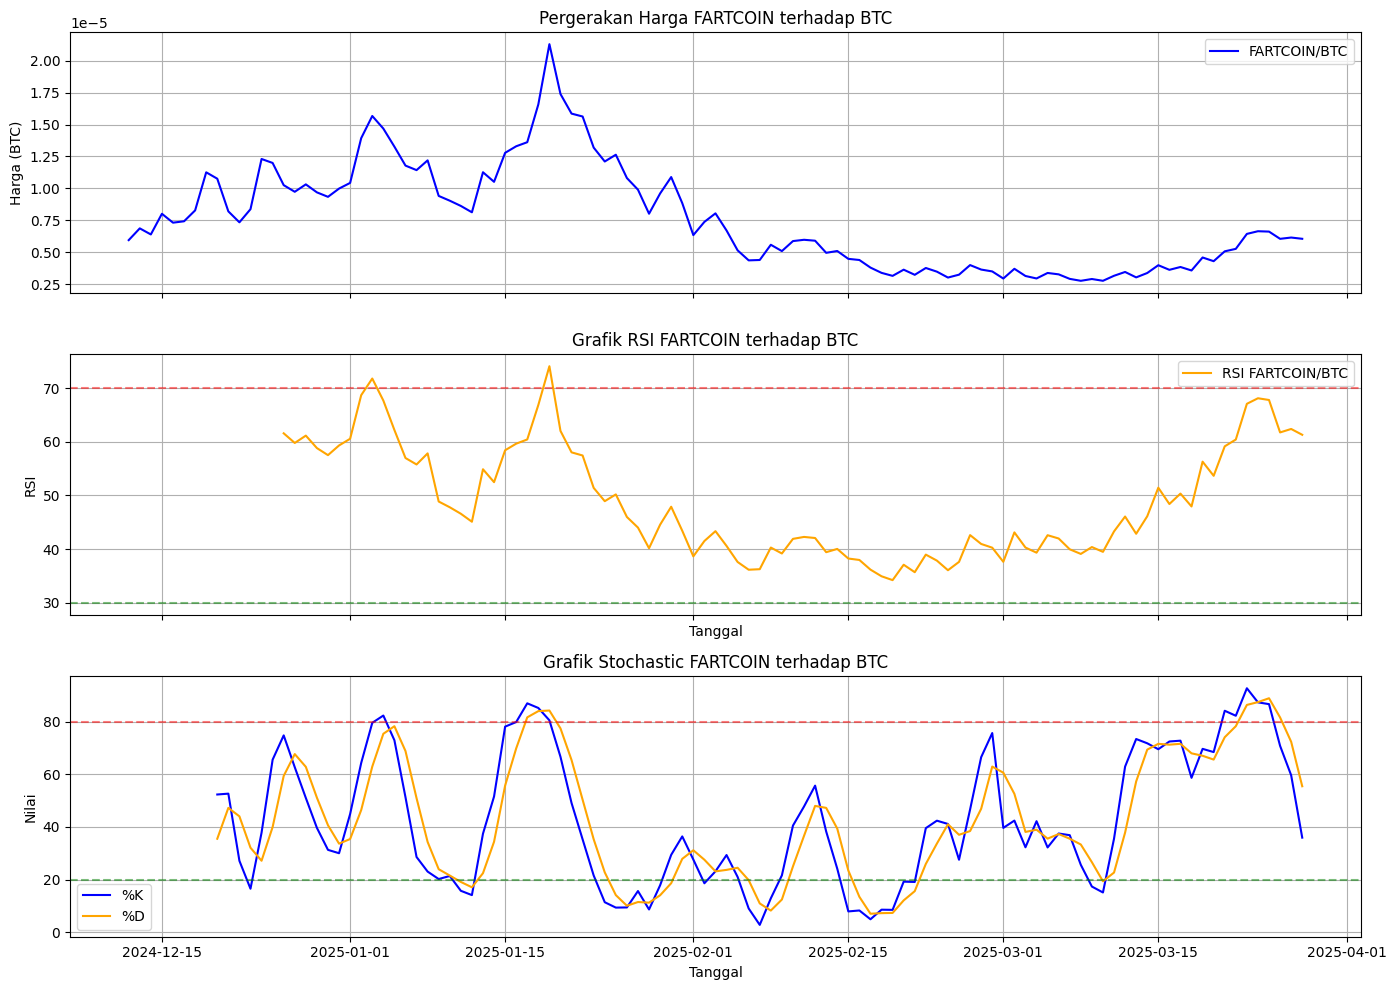

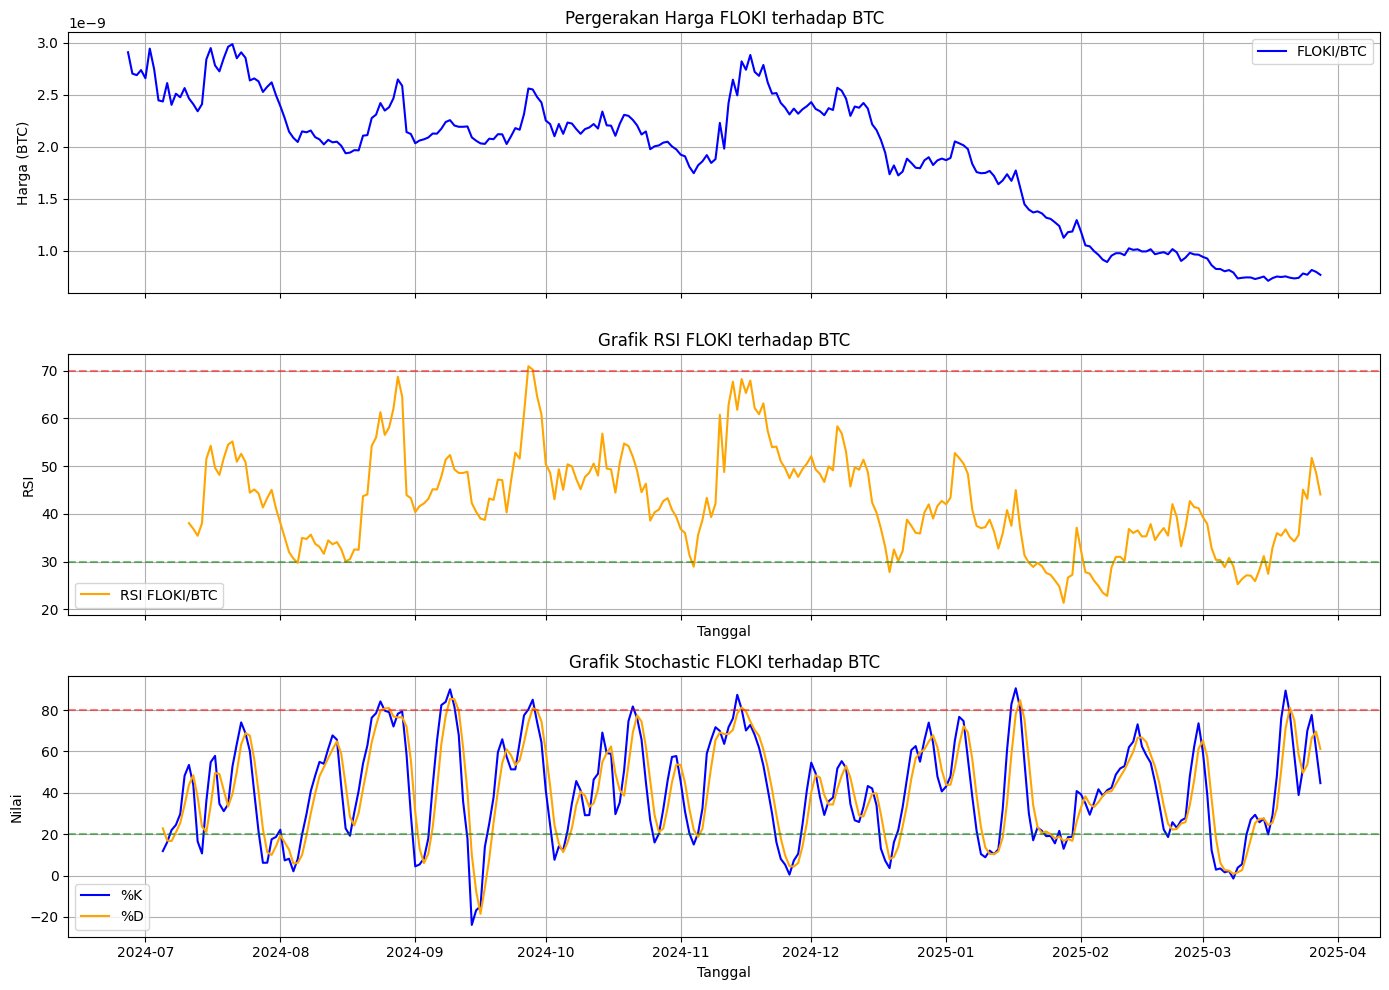

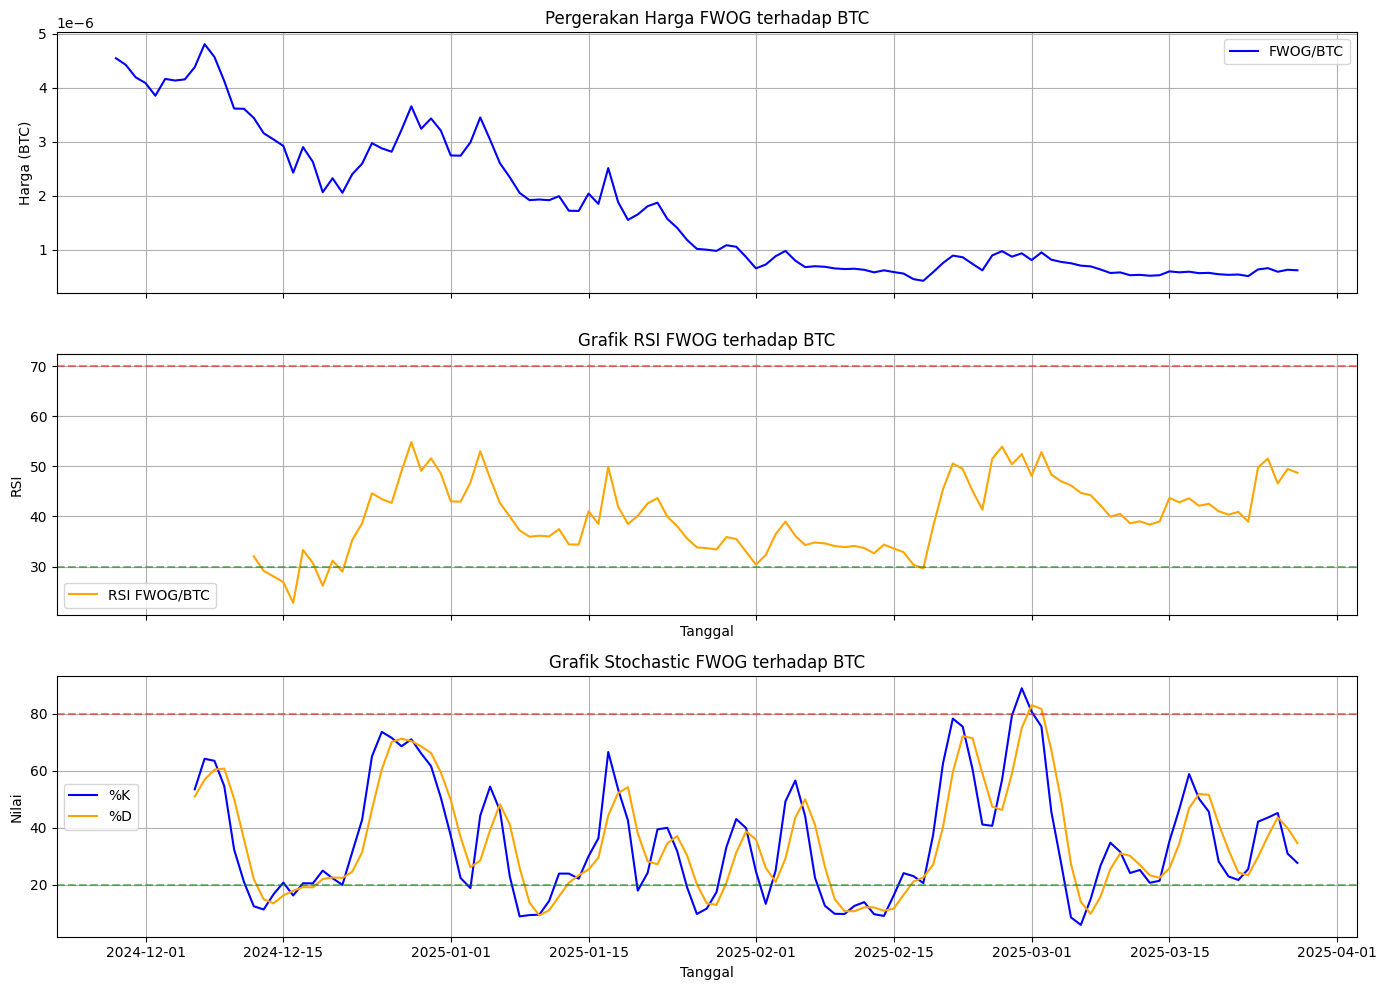

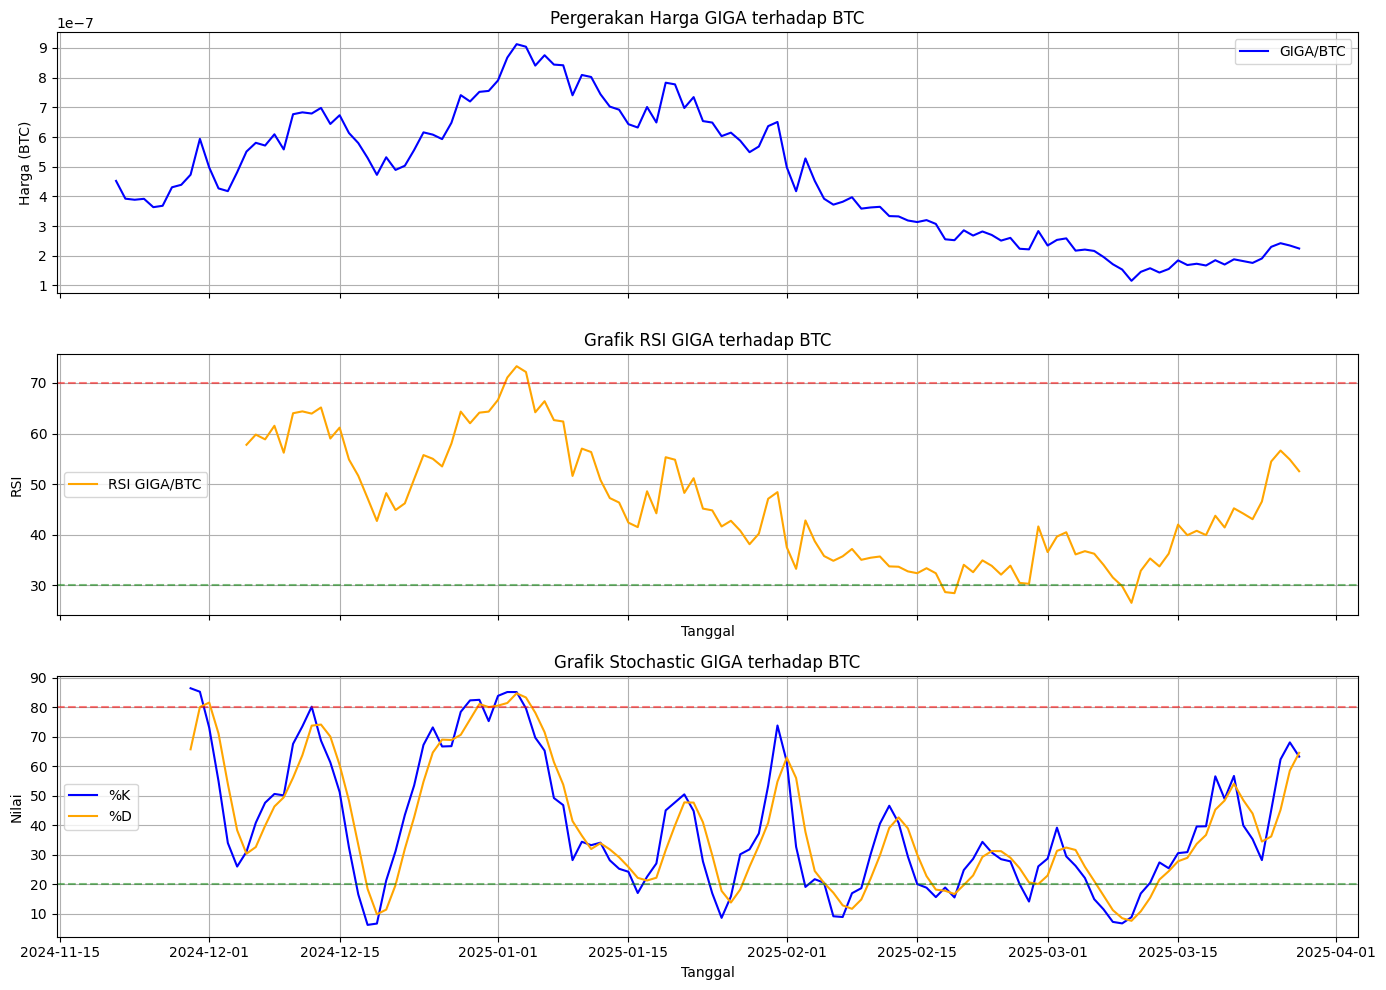

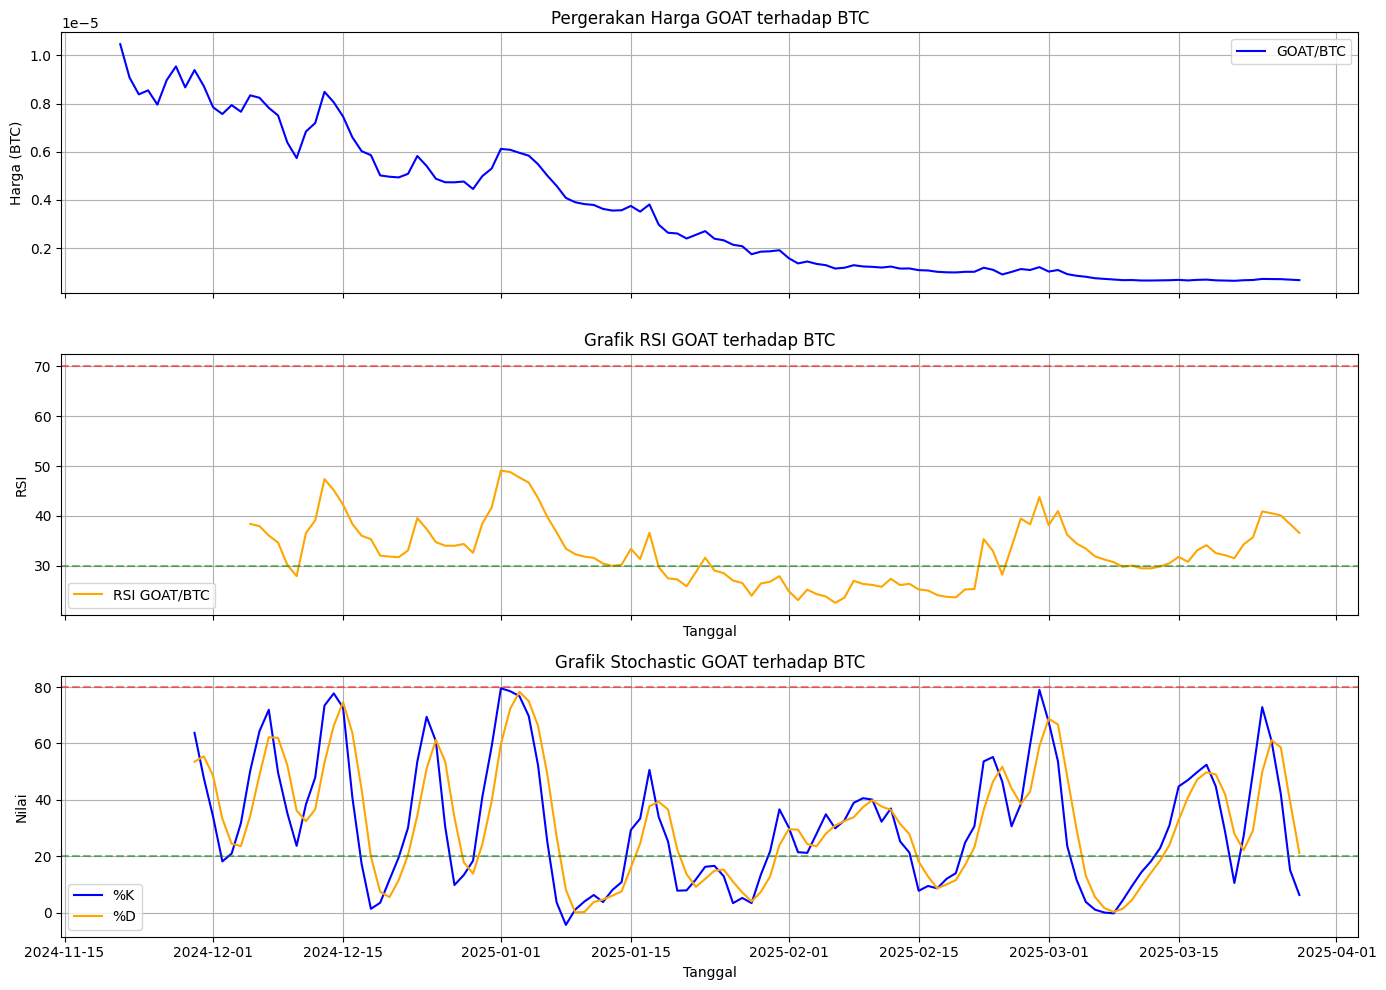

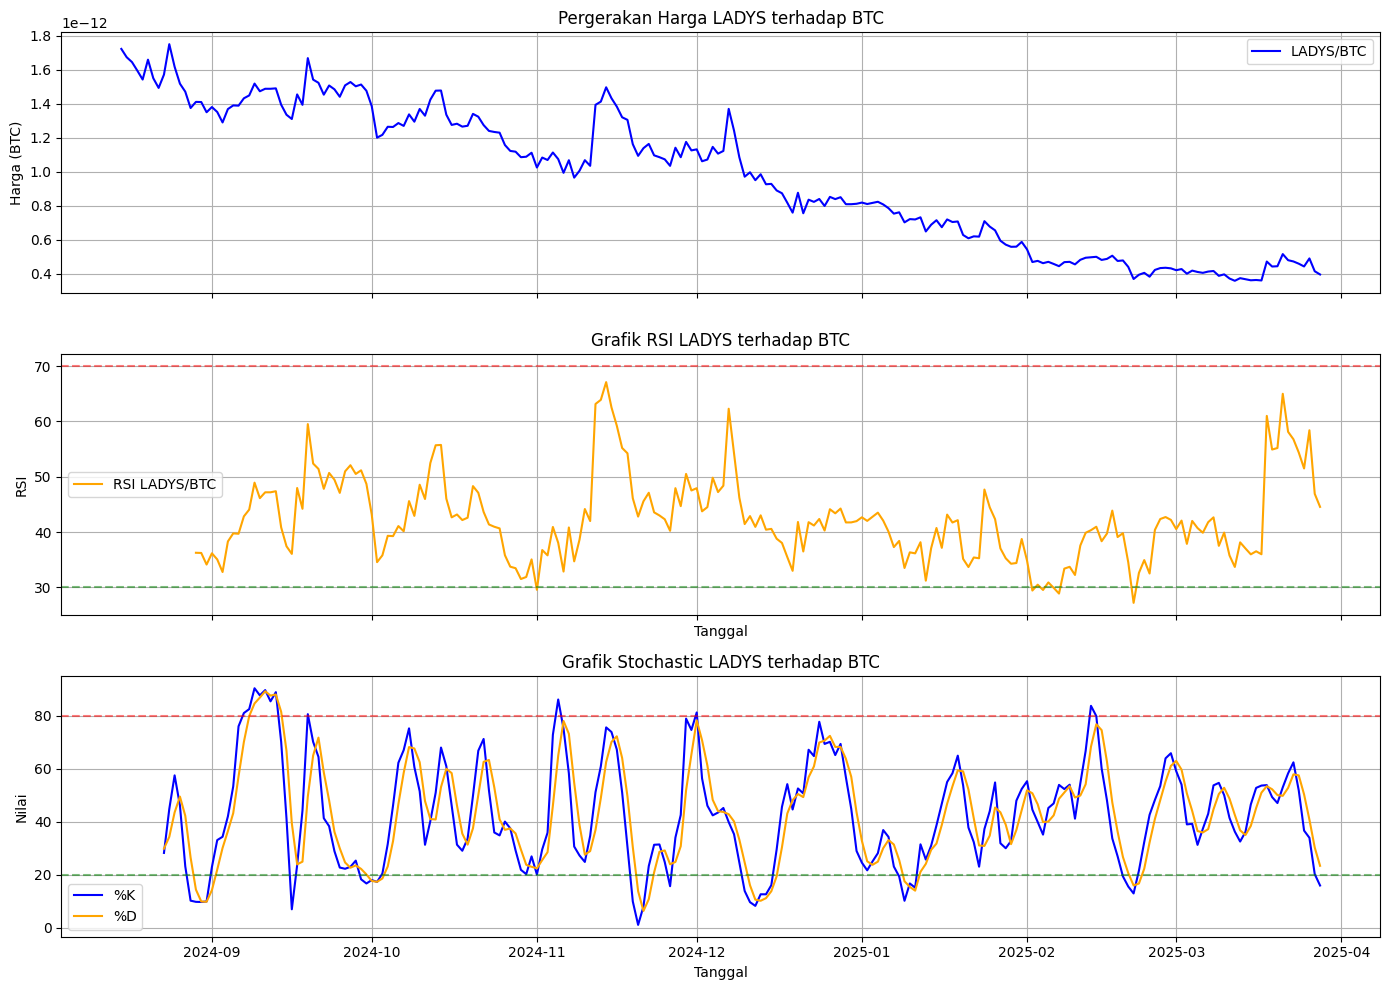

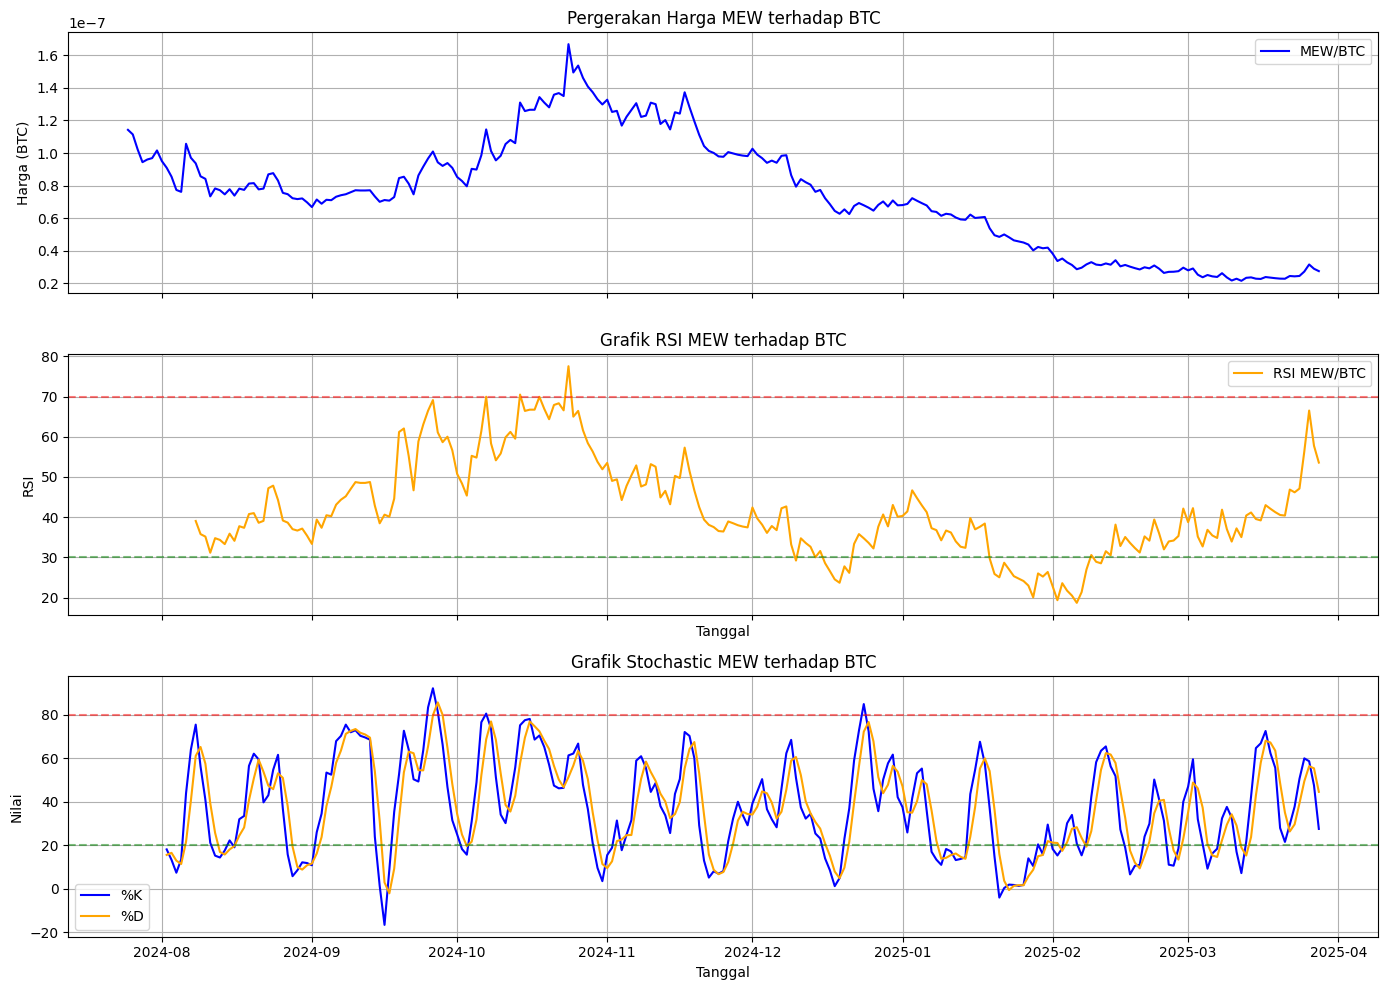

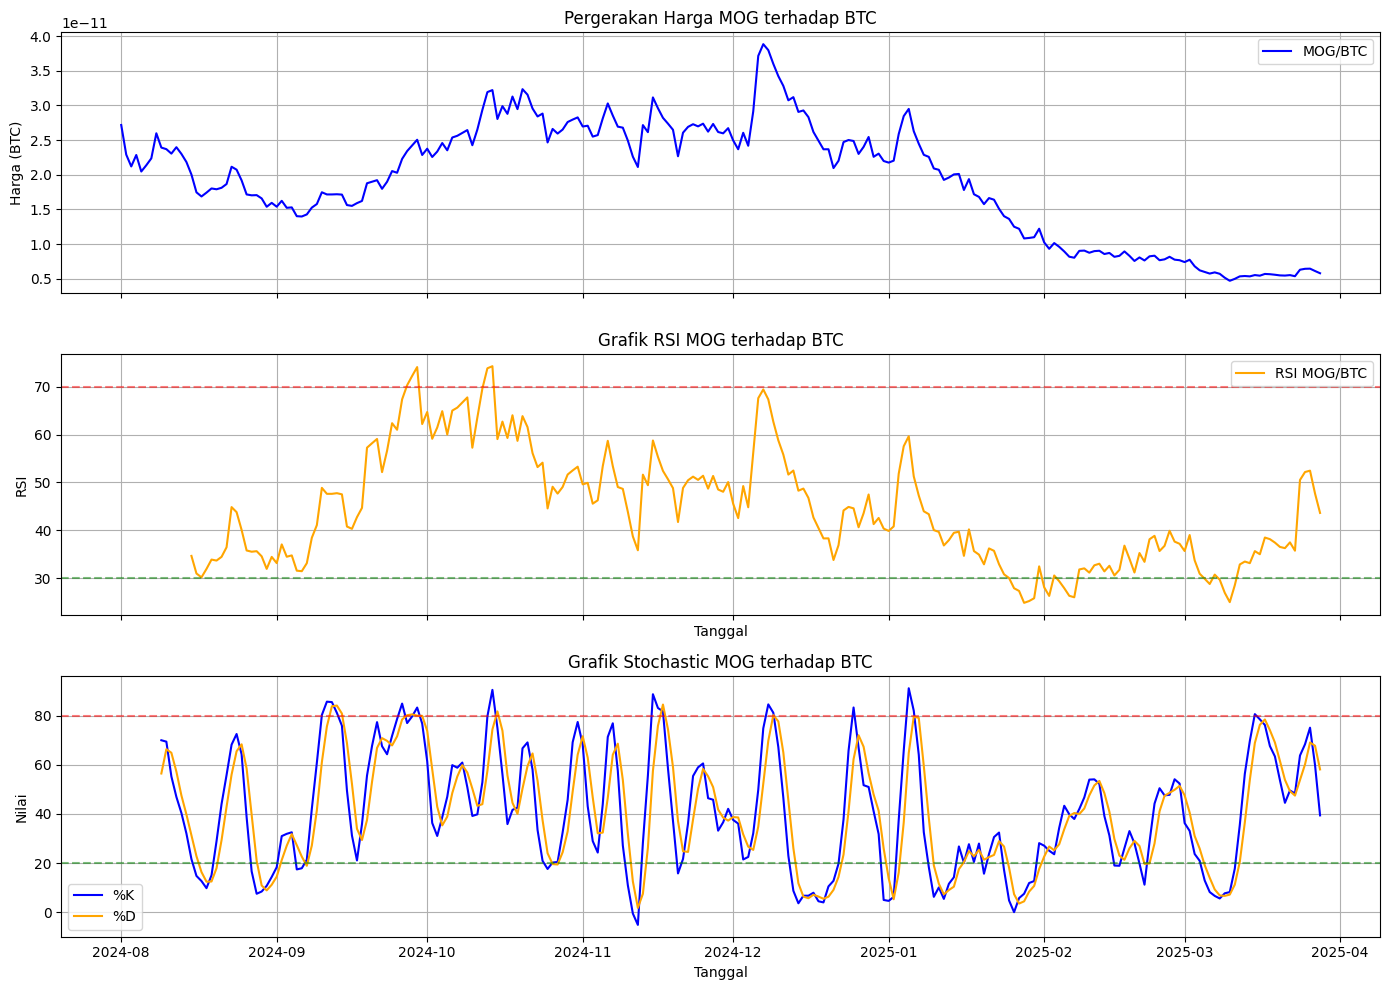

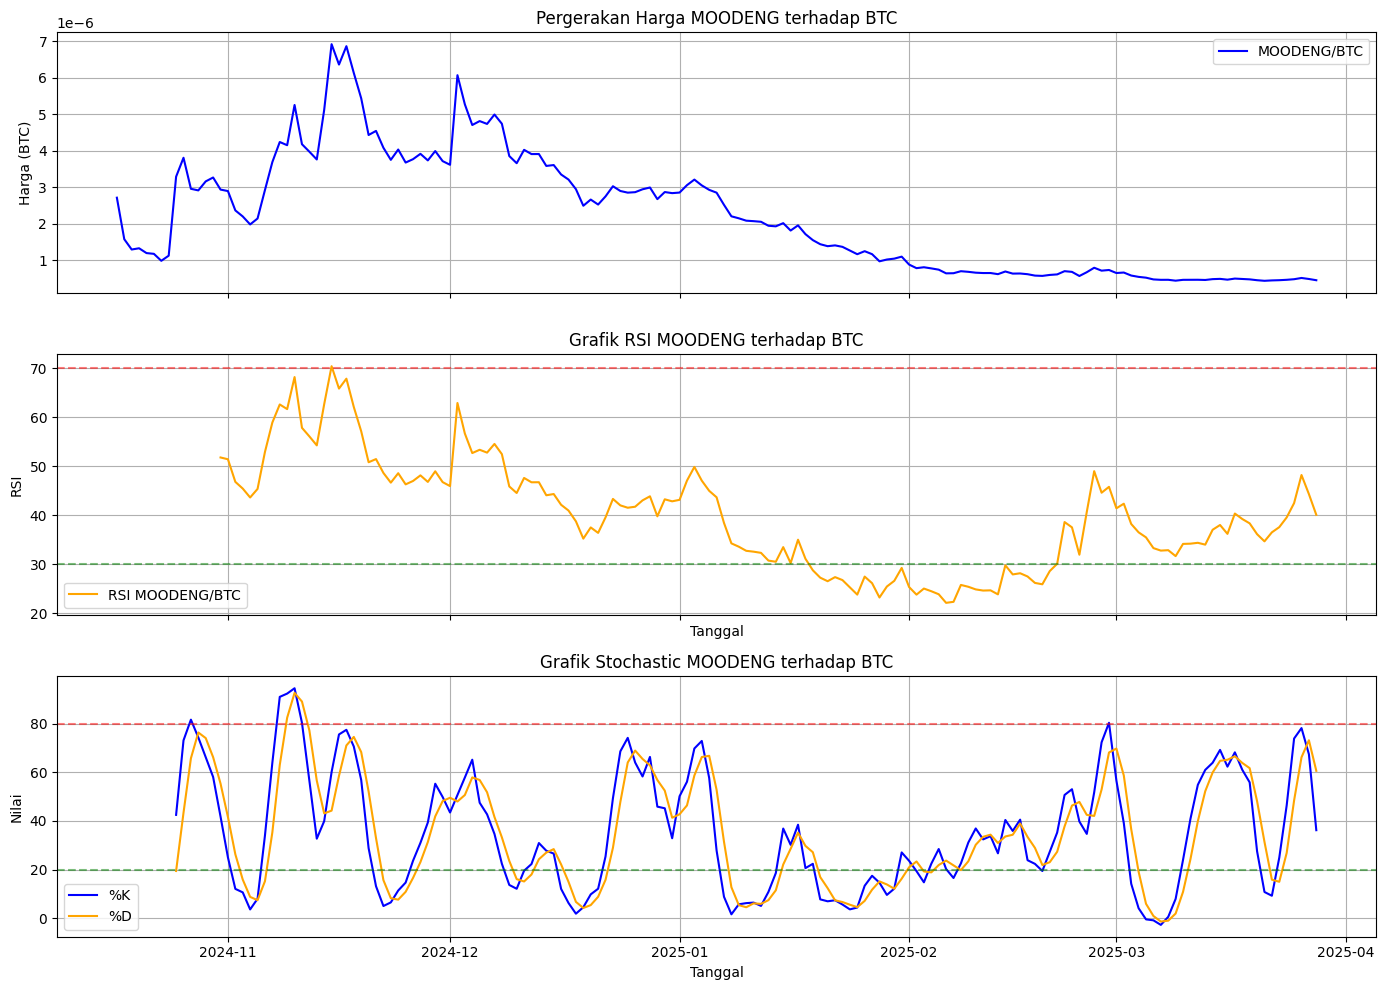

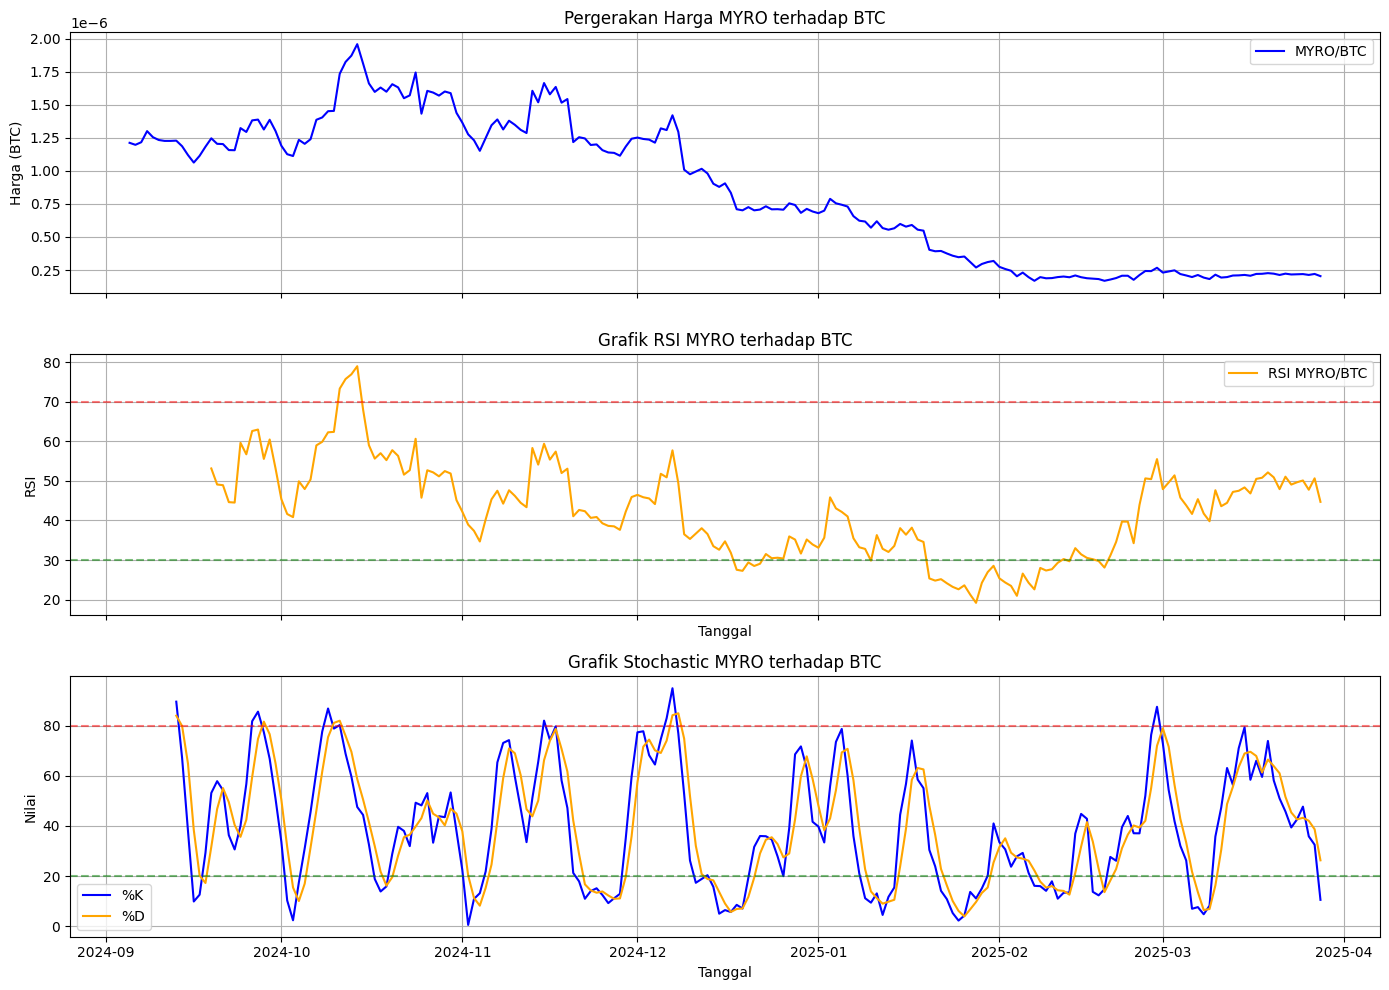

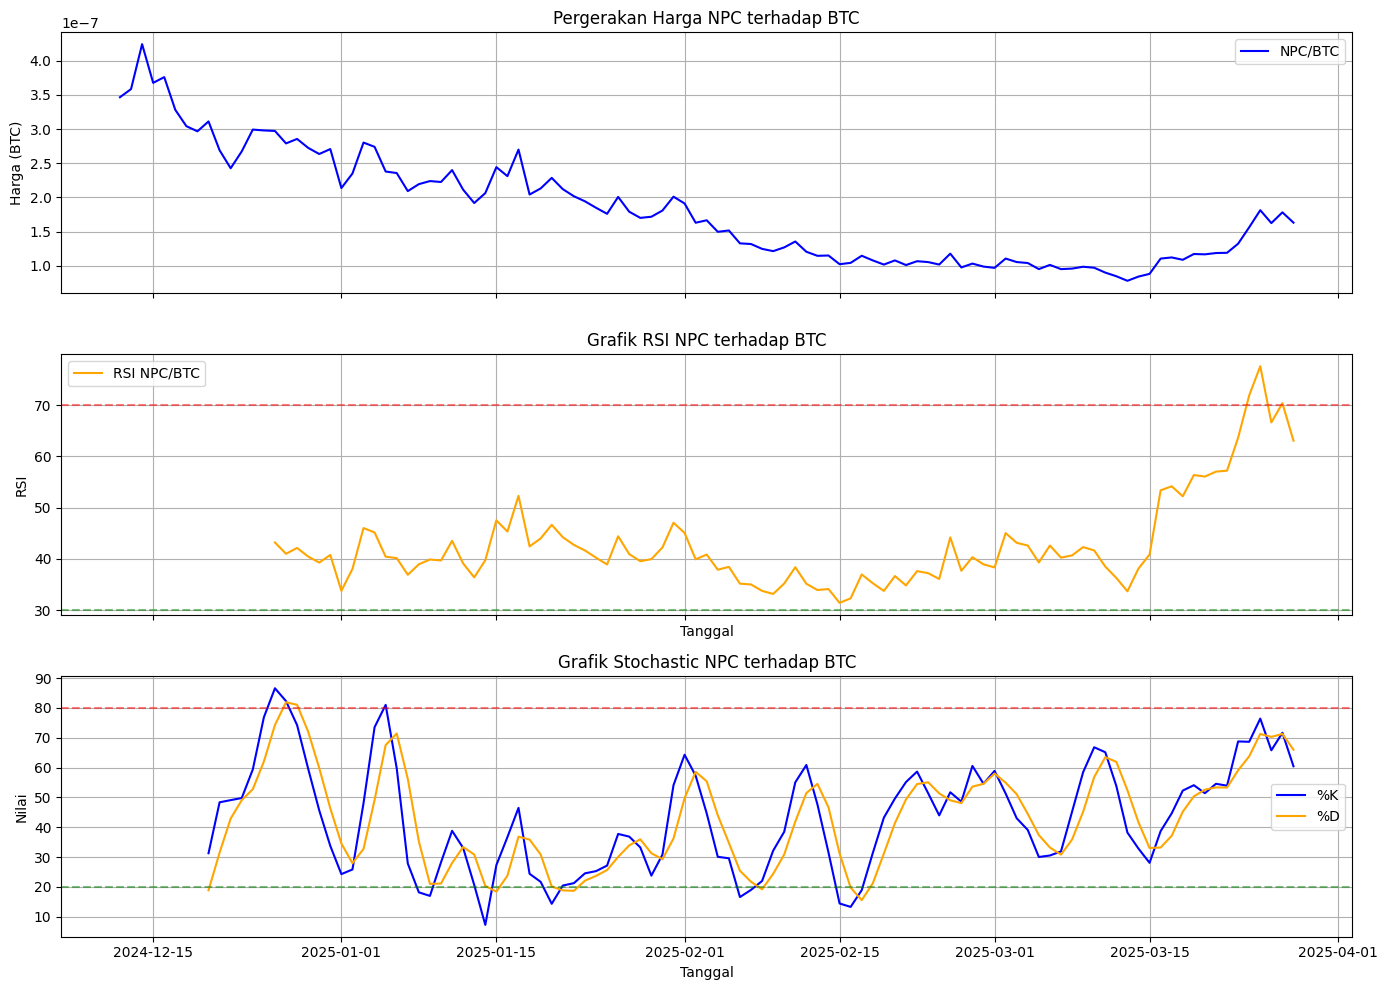

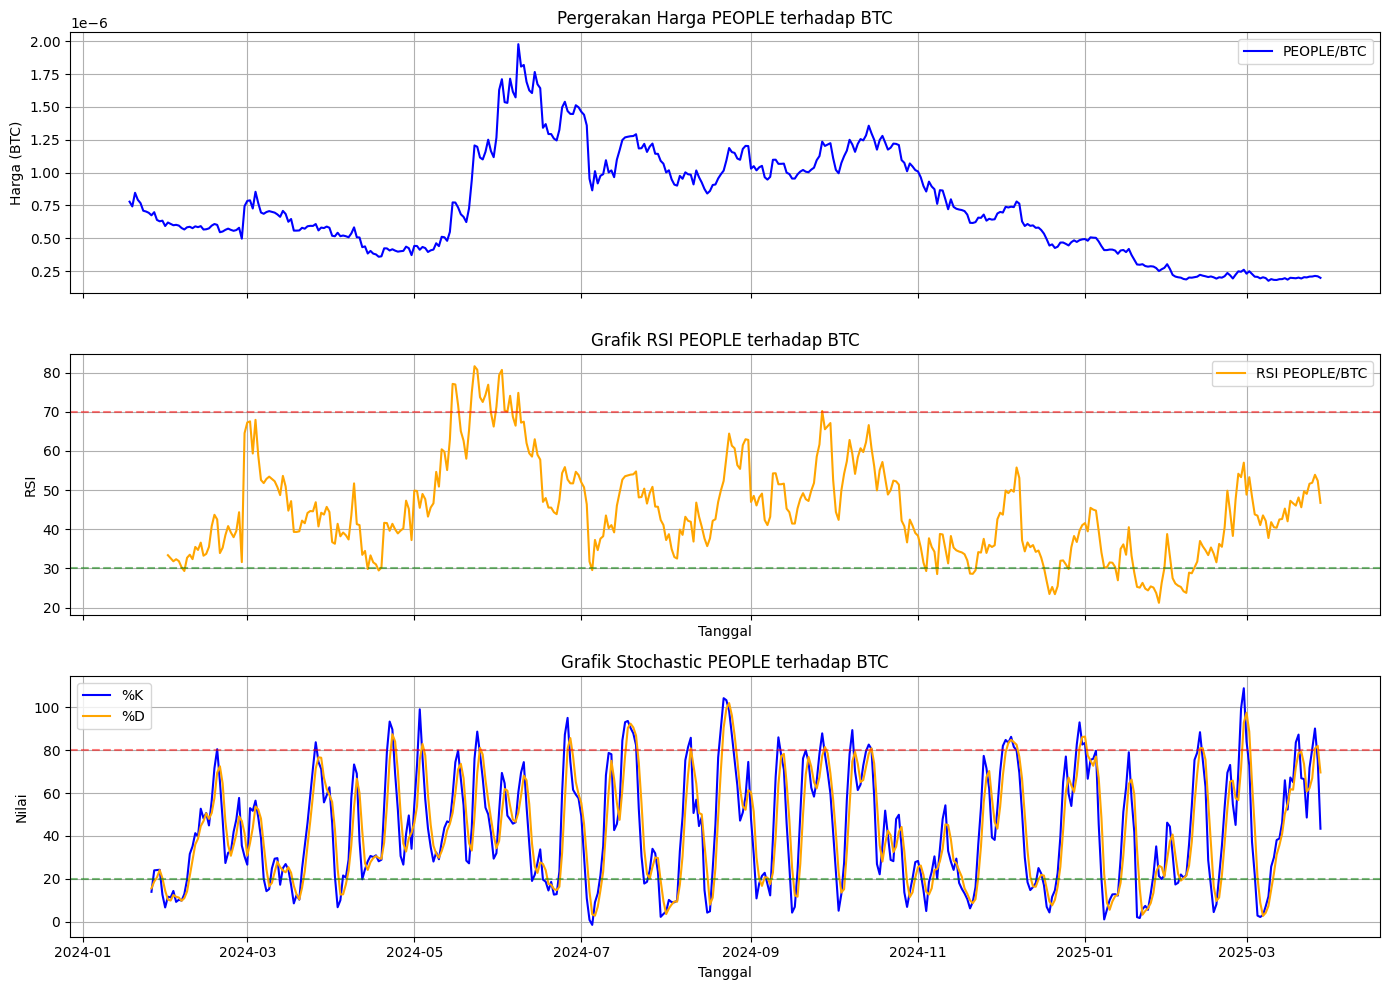

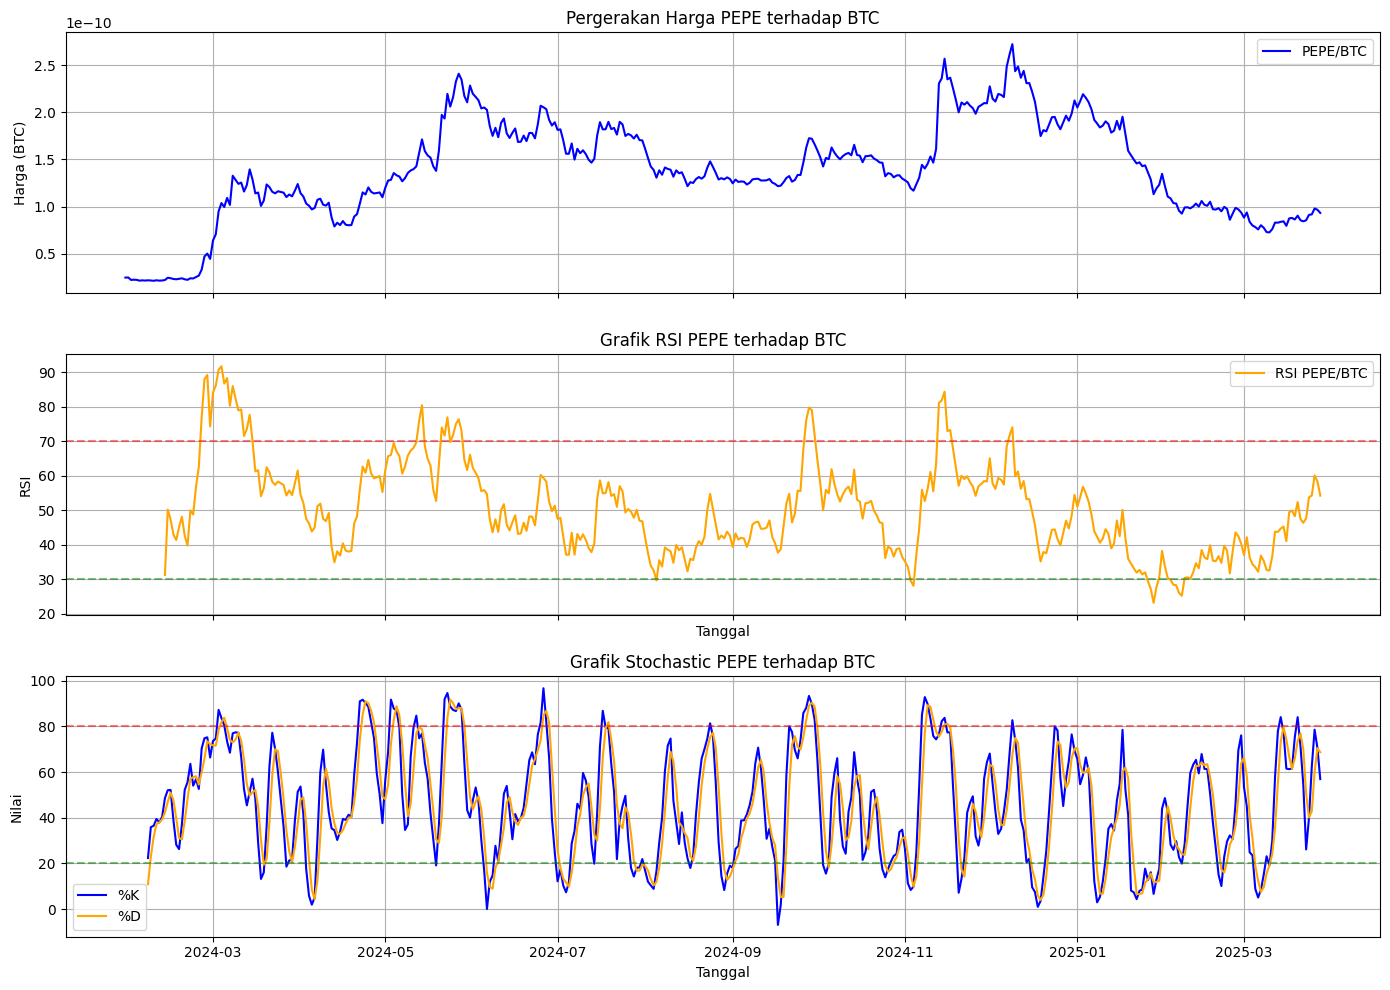

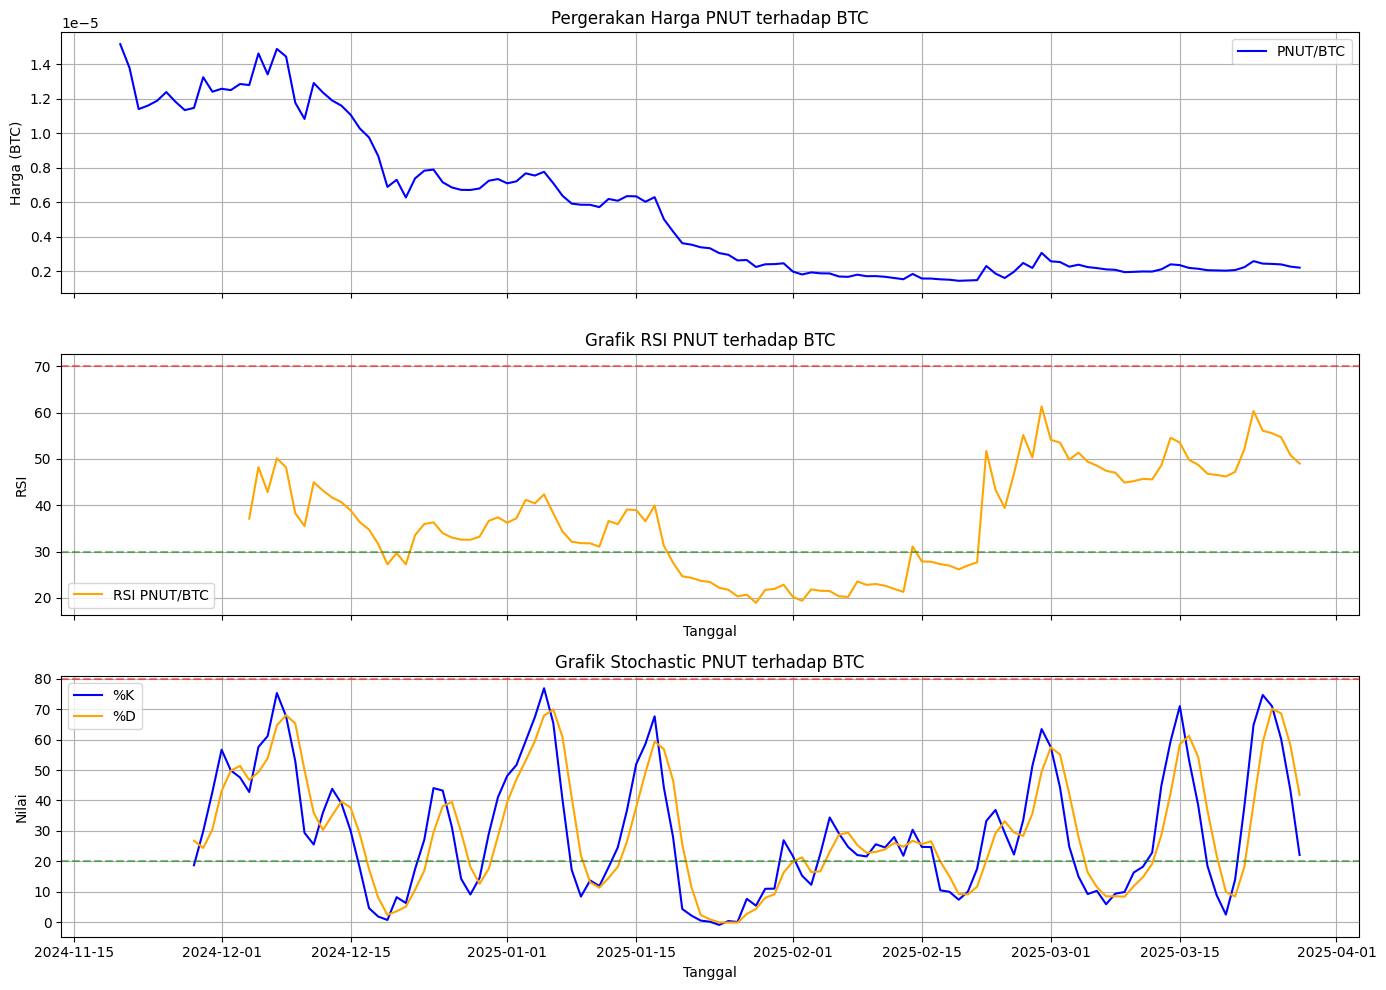

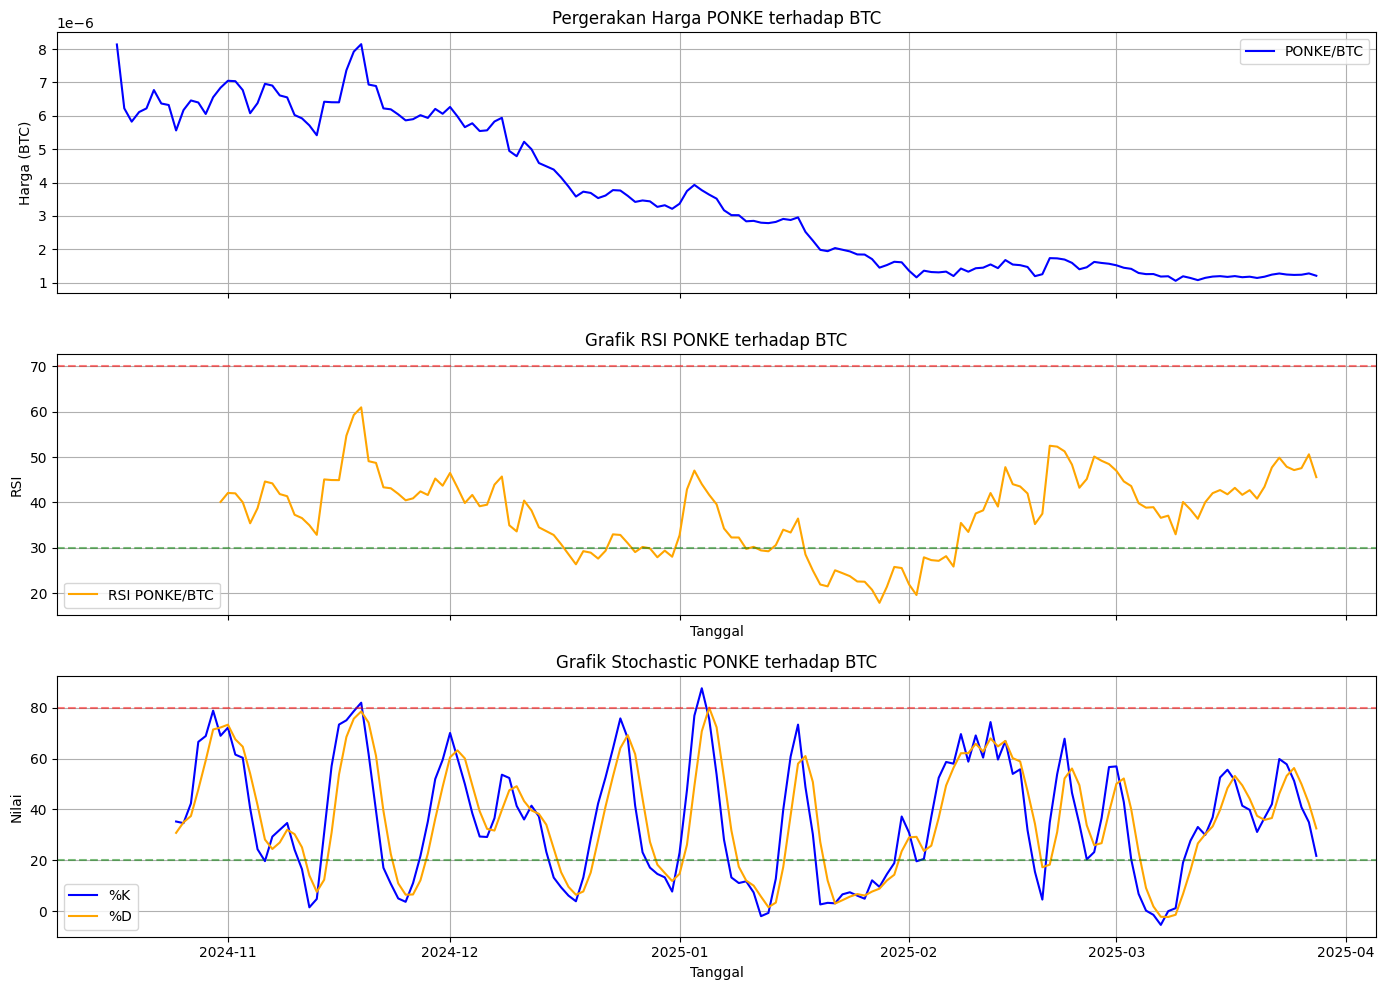

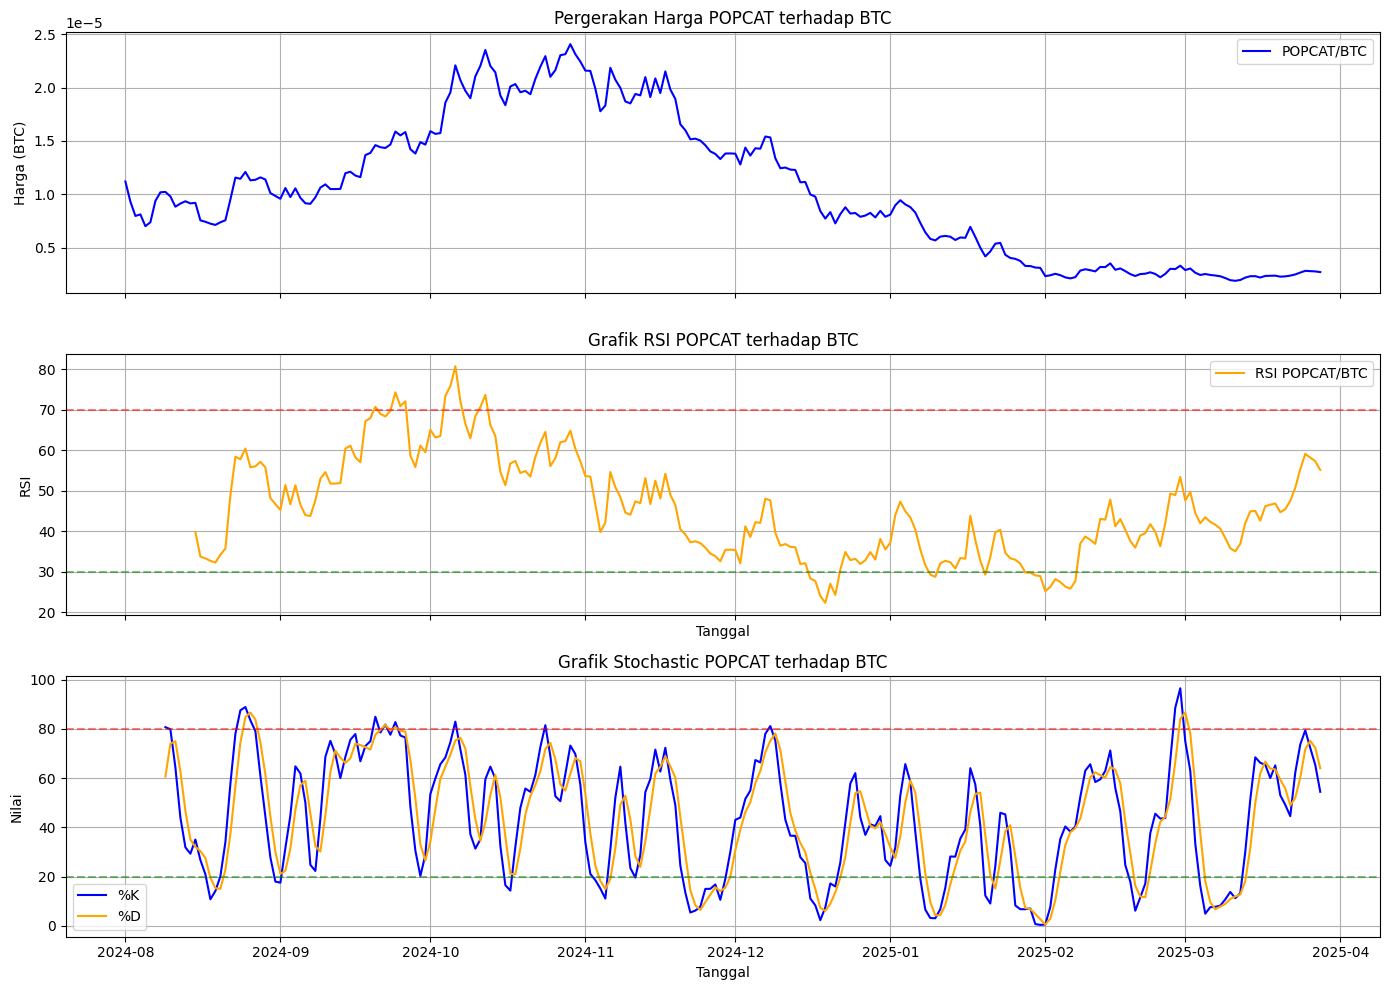

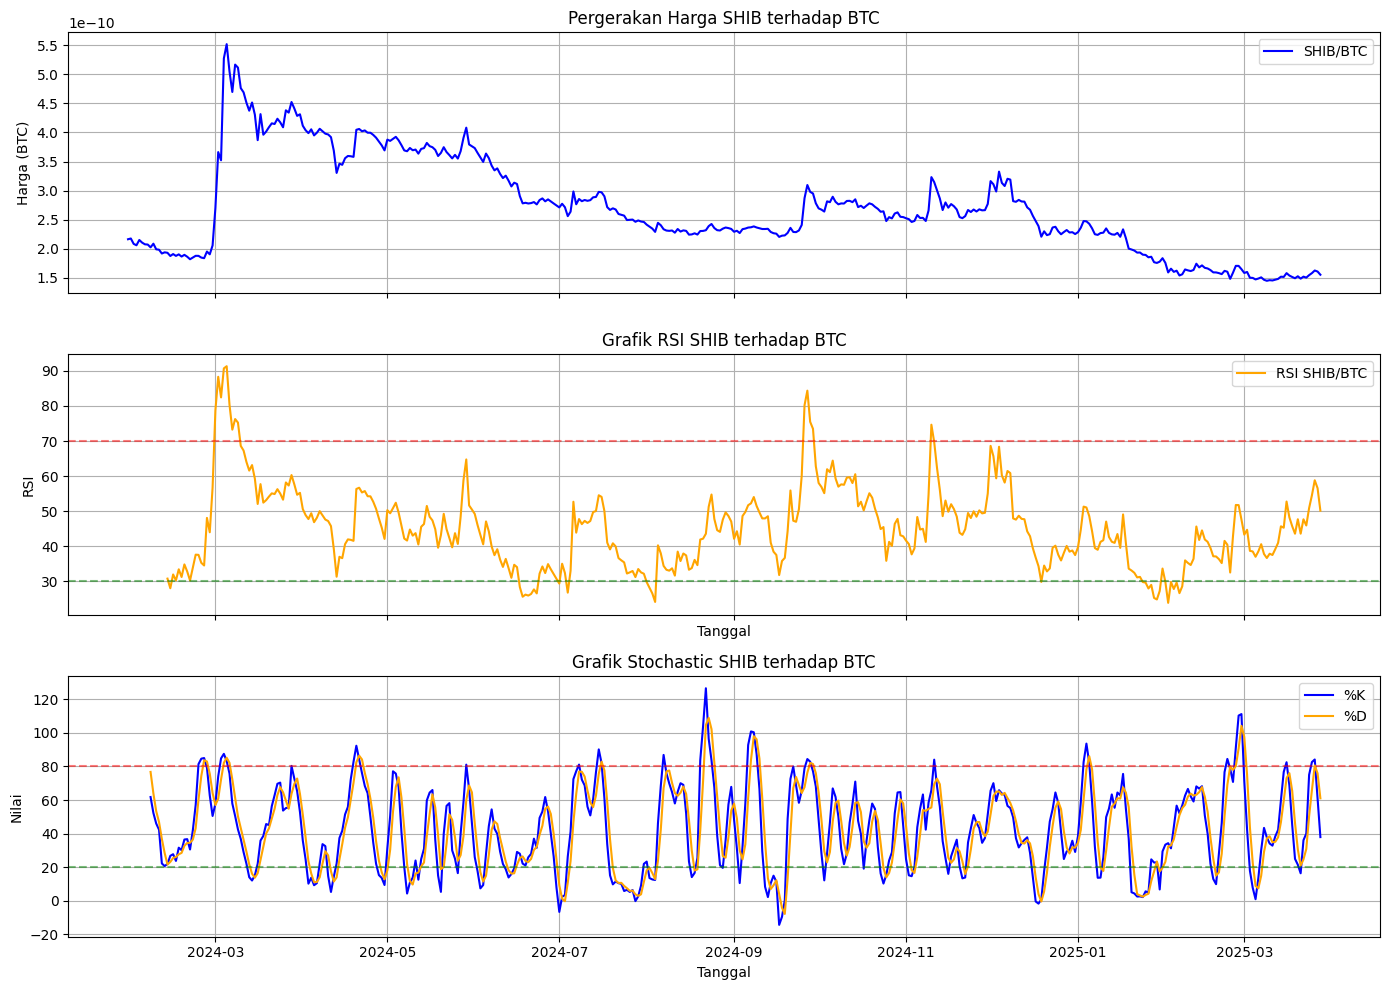

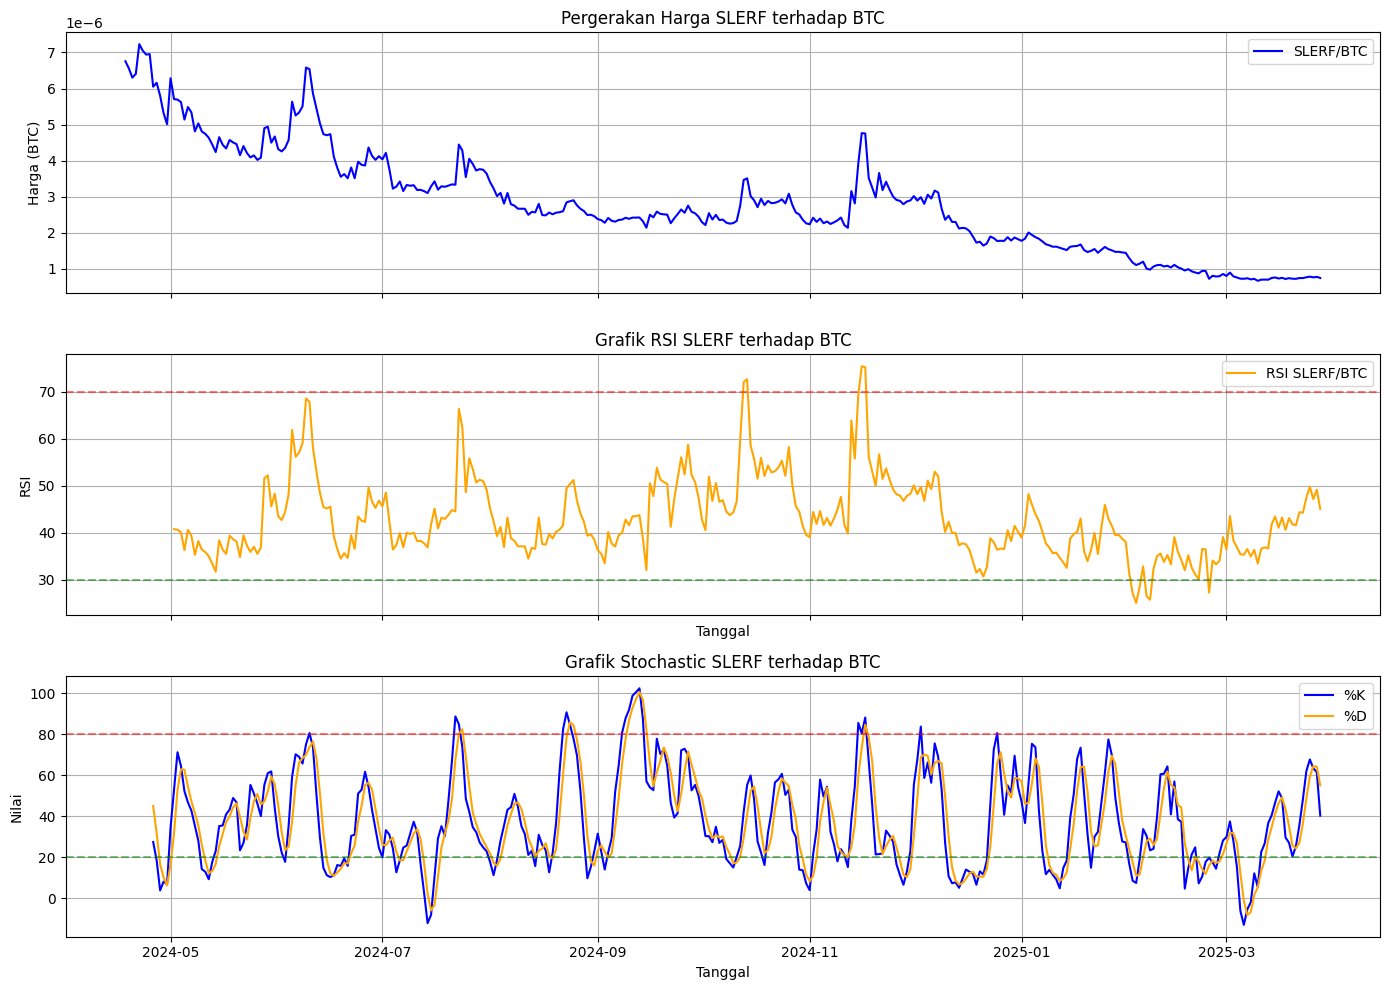

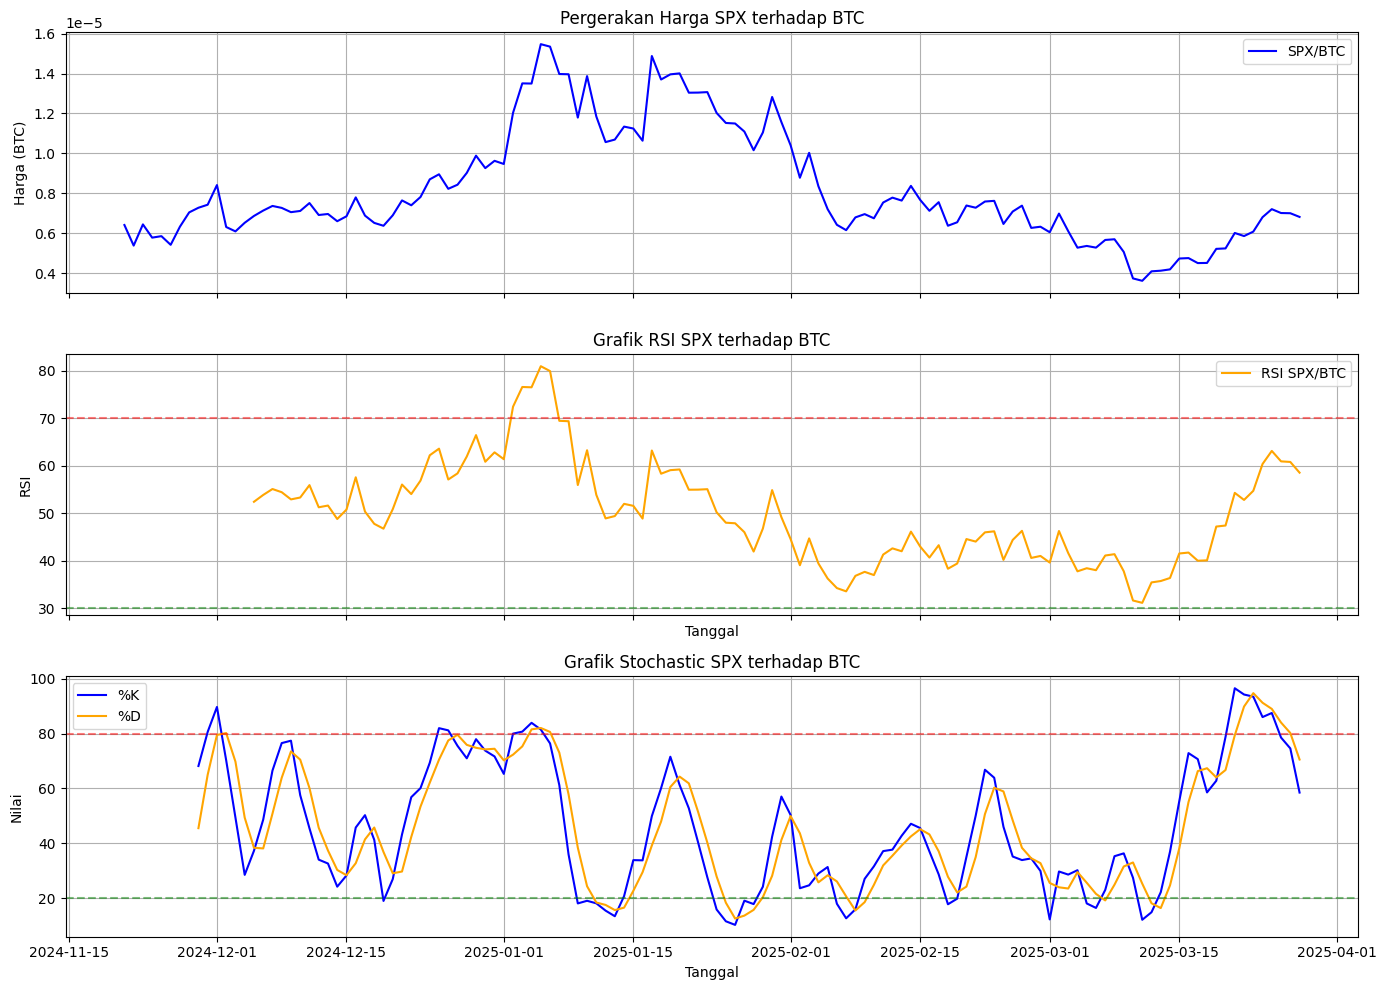

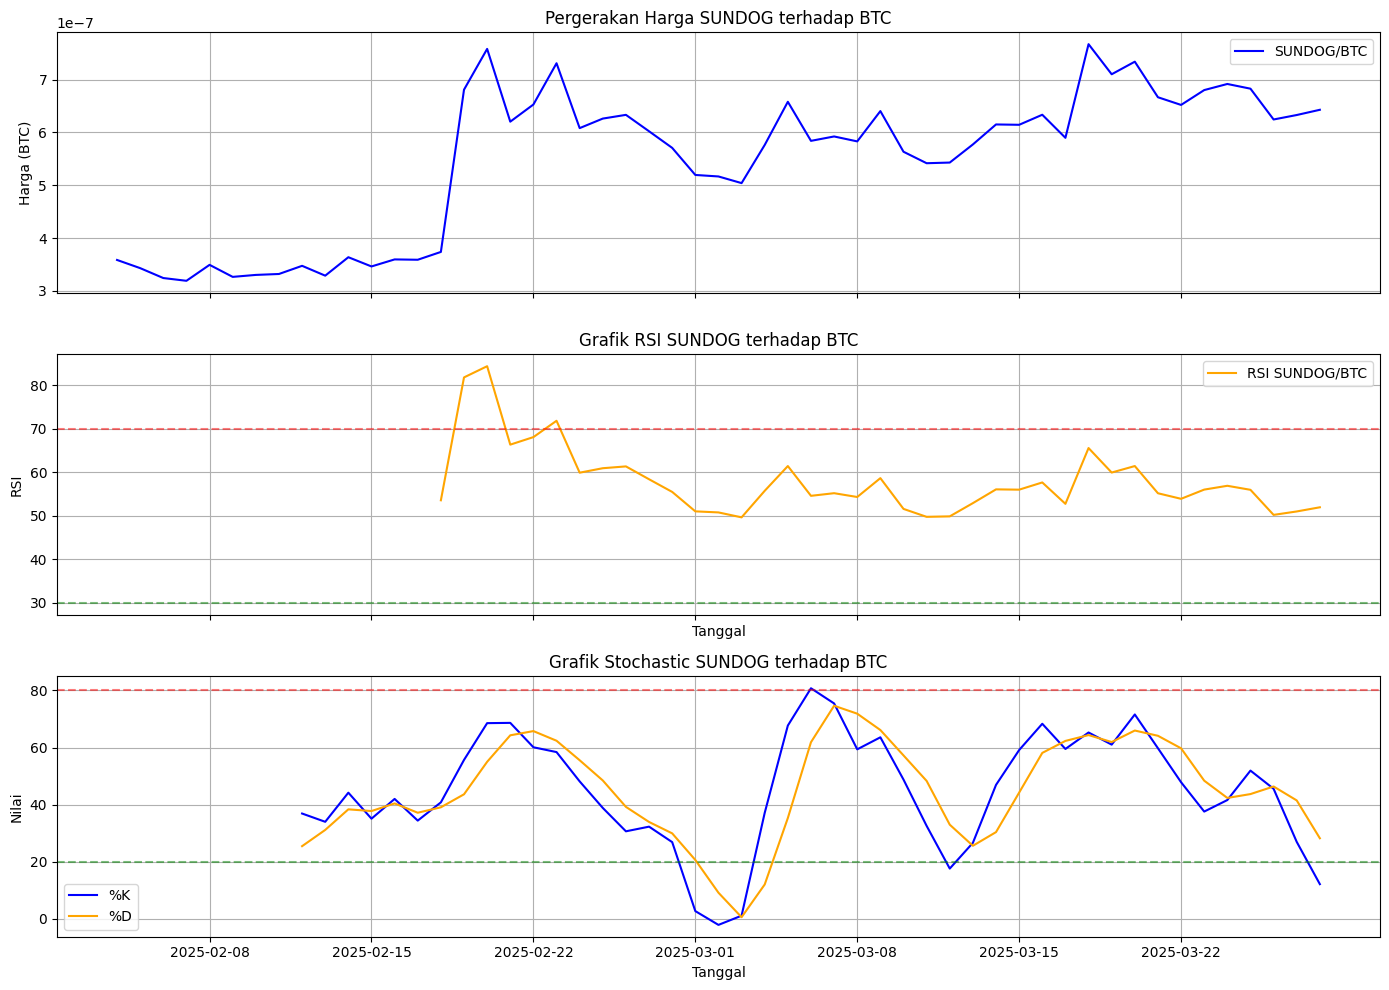

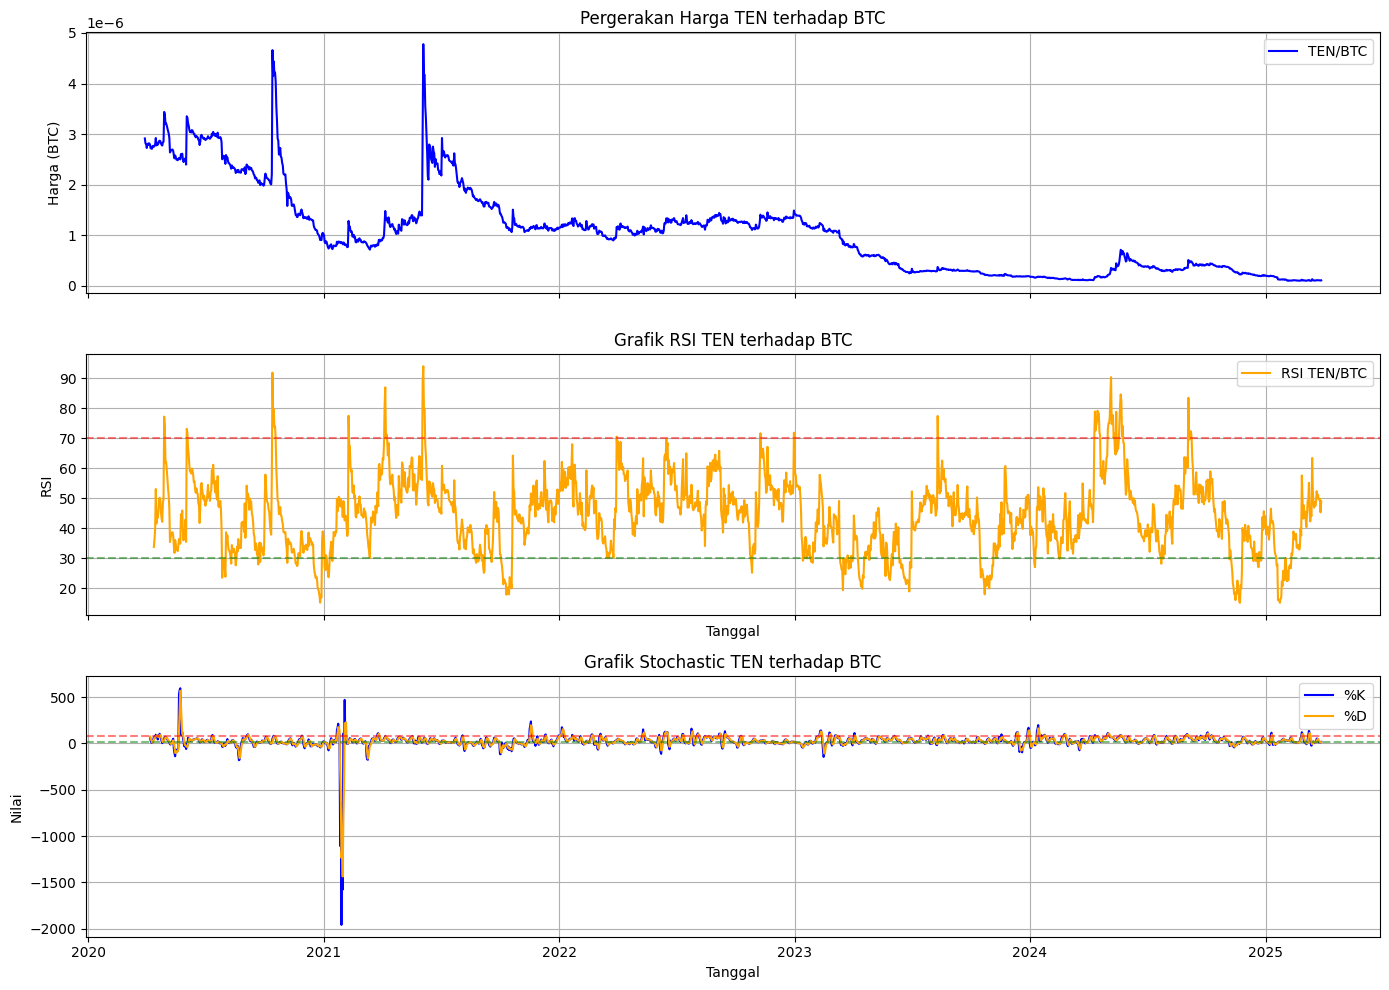

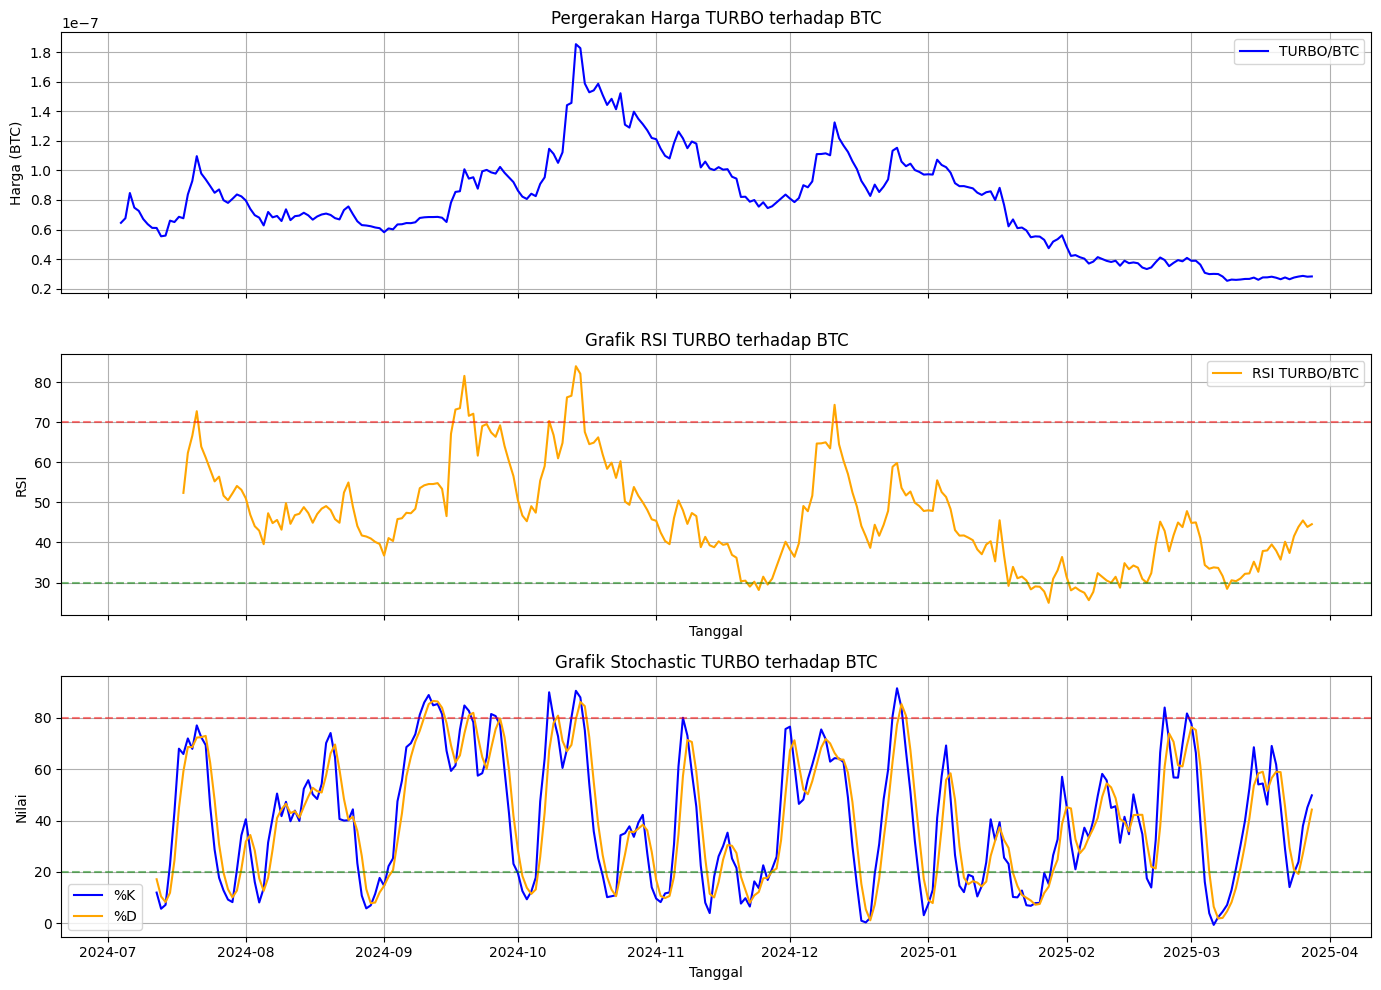

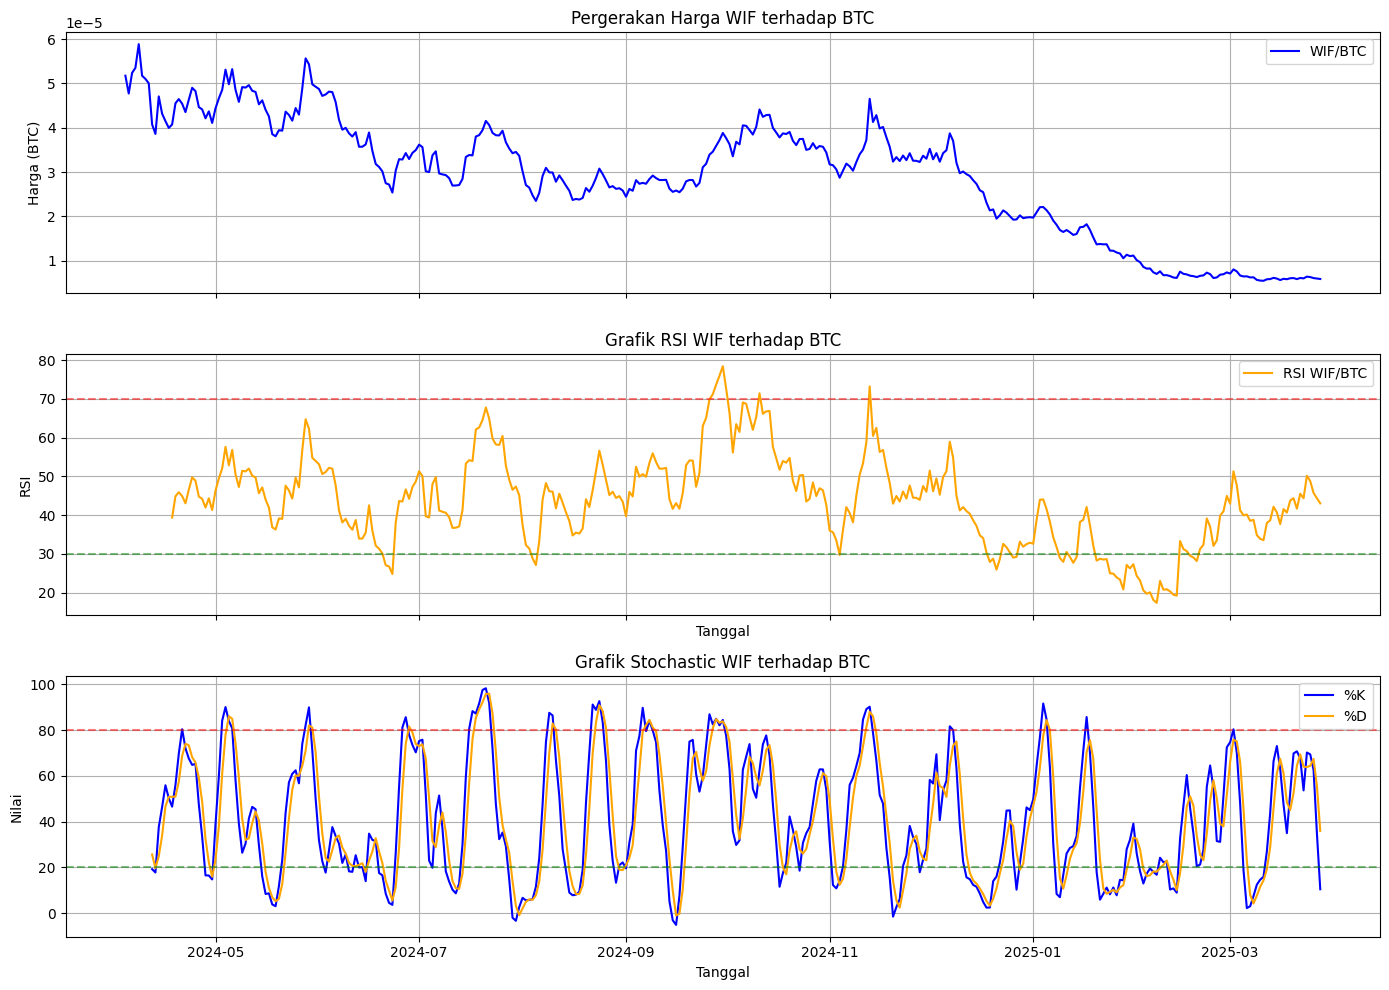

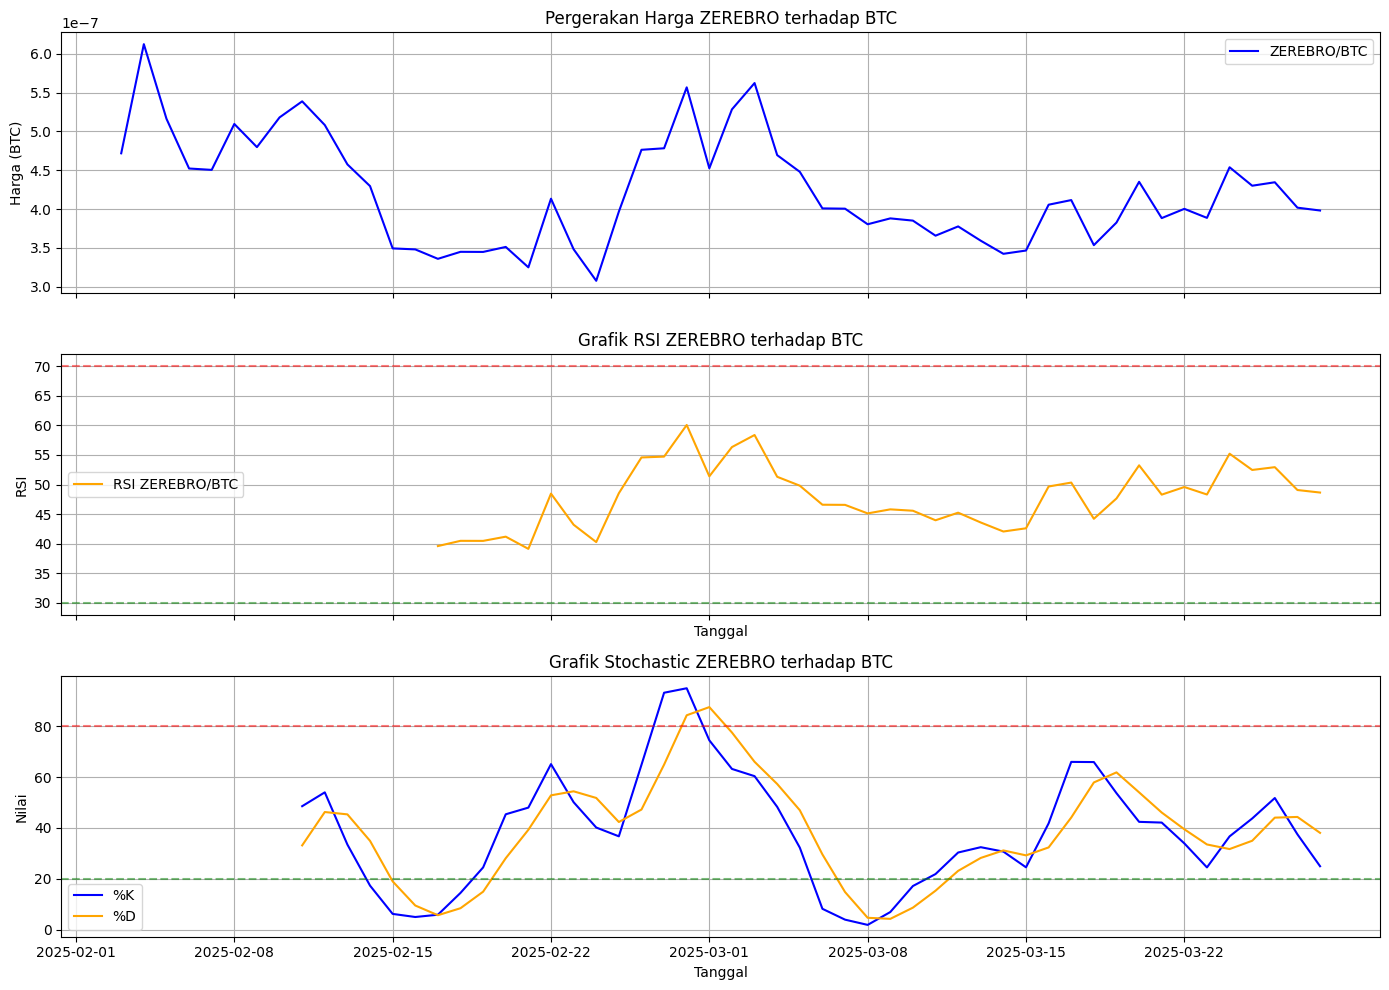

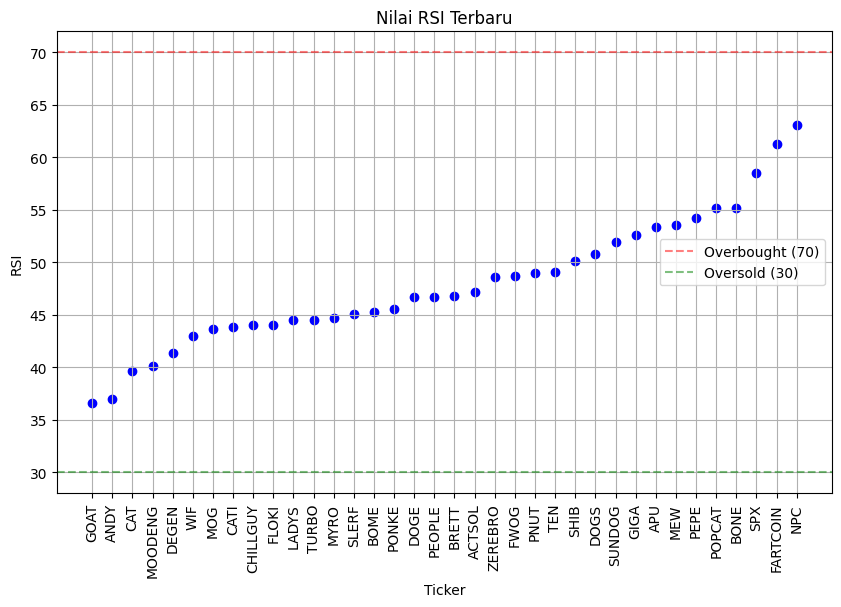

In [61]:
tickers = ['FARTCOIN', 'MOODENG', 'SPX', 'ZEREBRO', 'WIF', 'ACTSOL', 'LADYS', 'ANDY', 'APU', 'BOME', 'BONE', 'BRETT', 'CAT', 'CATI', 'CHILLGUY', 'DEGEN', 'DOGE', 'DOGS', 'FLOKI', 'FWOG', 'GIGA', 'GOAT', 'MYRO', 'MEW', 'MOG', 'PEPE', 'NPC', 'PEOPLE', 'PONKE', 'POPCAT', 'SHIB', 'SLERF', 'SUNDOG', 'TEN', 'TURBO', 'PNUT']

# tickers_error = ['NEIRO', 'VIRTUAL']

show_multiple_chart(tickers)

In [ ]:
tickers = [ 'AERO', 'ALTLAYER', 'API3', 'ARB', 'ARKM', 'ATH', 'AVAX', 'BGB', 'BNB', 'CAKE', 'CTC', 'CRV', 'CTK', 'EIGEN', 'ENA', 'ENS', 'ETH', 'FET', 'FIL', 'FLUX', 'FTM', 'GALA', 'GMT', 'GRASS', 'GRT', 'HBAR', 'HIFI', 'HNT', 'IMX', 'IO', 'ISLM', 'JASMY', 'JUP', 'JTO', 'KMNO', 'LDO', 'LPT', 'LQTY', 'MBOX', 'ME', 'METIS', 'MKR', 'MNT', 'MOVE', 'NEAR', 'OM', 'ONDO', 'PAXG', 'PENDLE', 'PHA', 'PYTH', 'POL', 'RAY', 'REZ', 'RENDER', 'SOL', 'STORJ', 'SUI', 'TON', 'TRX', 'UNI', 'WORMHOLE', 'XRP', 'ZKJ']

# tickers_error = ['AAVE', 'FORM', 'ID', 'XDC']

show_multiple_chart(tickers)
